# Summarize and aggregate susceptibility scores across all queries

In [1]:
%load_ext autoreload
%autoreload 2
# %load_ext lab_black

In [5]:
import os
import sys
import math
import random
from itertools import product
from tqdm import tqdm
from typing import Dict, List, Set, Union, Tuple
import yaml
from ast import literal_eval

import json
import pandas as pd
import seaborn as sns

# from transformers import GPTNeoXForCausalLM, AutoTokenizer
import torch
from typing import List
from matplotlib import font_manager as fm, pyplot as plt
import numpy as np
import wandb

# import statsmodels.api as sm

In [6]:
# IMPORTANT: Run as if from project root so that imports work.
pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
os.chdir(pardir)
os.getcwd()

'/cluster/work/cotterell/kdu/context-vs-prior-finetuning'

In [7]:
from utils import construct_paths_and_dataset_kwargs

# from analysis_helpers import (
#     compute_ttest_scores_dfs,
#     save_ttest_df_to_json,
#     count_open_closed_sig_group_match,
#     count_num_significant_queries,
#     combine_open_and_closed_dfs,
#     write_to_latex_test_results_by_qid,
#     write_to_latex_test_sus_and_per_results_by_qid,
#     explode_val_df_per_qe,
#     convert_test_results_dict_to_df,
#     convert_test_results_dict_to_sig_proportion_df,
#     build_mean_effect_sz_df,
#     get_param_size,
#     get_test_results_and_plot_per_model,
#     plot_prop_queries_significant_per_model,
#     plot_effect_sz_per_model,
# )

/cluster/home/kevidu/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#b40426


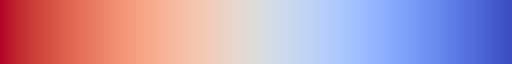

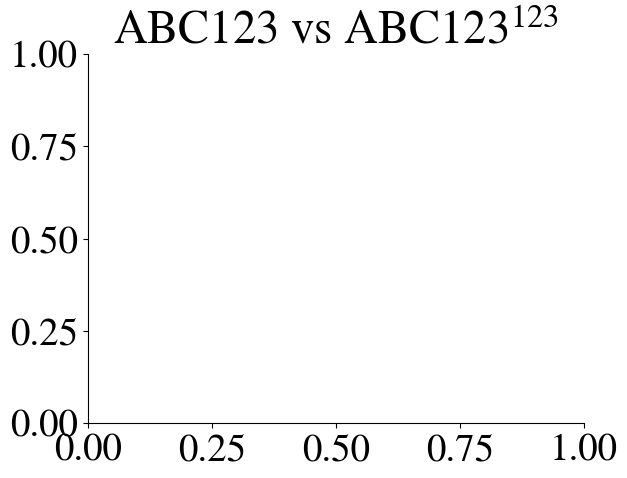

In [8]:
# from analysis.mpl_styles import *
import matplotlib
import seaborn as sns

# matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams["mathtext.rm"] = "Bitstream Vera Sans"
matplotlib.rcParams["mathtext.it"] = "Bitstream Vera Sans:italic"
matplotlib.rcParams["mathtext.bf"] = "Bitstream Vera Sans:bold"
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = "28"

matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
ENTITY_COLOR = palette[0]
CONTEXT_COLOR = palette[1]

OPEN_COLOR = palette[2]
CLOSED_COLOR = palette[3]
LINE_COLOR = palette[7]

REAL_COLOR = palette[5]
FAKE_COLOR = palette[7]
DIFF_COLOR = palette[6]

open_closed_colormap = {"closed": CLOSED_COLOR, "open": OPEN_COLOR}
comparison_colormap = {
    "Familiar vs unfamiliar entities": palette[0],
    "Assertive vs base contexts": palette[1],
    "Negation vs base contexts": palette[3],
    "Relevant vs irrelevant contexts": palette[5],
}

matplotlib.pyplot.title(r"ABC123 vs $\mathrm{ABC123}^{123}$")
matplotlib.rcParams["mathtext.rm"]

cm = sns.color_palette("coolwarm_r", as_cmap=True)
cm.set_bad(cm(-np.inf))
print(matplotlib.colors.to_hex(cm(-np.inf)))
cm

In [9]:
##################
### Parameters ###
##################

# Data parameters

# wandb stuff
PROJECT_NAME = "sftcontext"
GROUP_NAME = None
TAGS = ["basefakepedia", "analysis", "summarize", "across-models"]
LOG_DATASETS = True

### Construct dataframes for analysis

In [10]:
analysis_dir = "analysis/summarize/across_models"
os.makedirs(analysis_dir, exist_ok=True)

In [13]:
dataset_names = ["BaseFakepedia"]
subsplit_names = [
    "nodup_relpid",
    # "nodup_relpid_obj",
    "nodup_relpid_subj",
    "nodup_s_or_rel_or_obj",
    "base",
]
seeds = [0]
train_sizes = [640]
no_train_statuses = [True, False]
peft_modules = [
    json.dumps(["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"], separators=(",", ":")),
    json.dumps(["gate_proj", "up_proj", "down_proj"], separators=(",", ":")),
    json.dumps(["q_proj", "k_proj", "v_proj", "o_proj"], separators=(",", ":")),
    json.dumps(["q_proj", "k_proj", "v_proj"], separators=(",", ":")),
]

model_id_and_bs_and_ga_and_quantize_and_peft_tuples = [
    ("unsloth/mistral-7b-v0.2-bnb-4bit", 4, 4, "4bit", True),
    # ("unsloth/mistral-7b-instruct-v0.2-bnb-4bit", 4, 4, "4bit", True),
    # ("unsloth/llama-2-7b-bnb-4bit", 4, 4, "4bit", True),
    ("unsloth/llama-2-7b-chat-bnb-4bit", 4, 4, "4bit", True),
    ("unsloth/llama-3-8b-bnb-4bit", 4, 4, "4bit", True),
    ("unsloth/llama-3-8b-Instruct-bnb-4bit", 4, 4, "4bit", True),
    # ("unsloth/gemma-2b-bnb-4bit", 4, 4, "4bit", True),
    ("unsloth/gemma-7b-bnb-4bit", 4, 4, "4bit", True),
    # ("unsloth/gemma-2b-it-bnb-4bit", 4, 4, "4bit", True),
    ("unsloth/gemma-7b-it-bnb-4bit", 4, 4, "4bit", True),
]

overwrite = False
df_dict = []

for ds in dataset_names:
    for sp in subsplit_names:
        for seed in seeds:
            for ts in train_sizes:
                for nts in no_train_statuses:
                    for pm in peft_modules:
                        for model_id, bs, ga, quantize, peft in model_id_and_bs_and_ga_and_quantize_and_peft_tuples:
                            dict_vals = dict(
                                DATASET_NAME=ds,
                                SUBSPLIT=sp,
                                SEED=seed,
                                TRAIN_SIZE=ts,
                                MODEL_ID=model_id,
                                PEFT=peft,
                                LORA_MODULES=json.loads(pm),
                                LOAD_IN_4BIT=(quantize == "4bit"),
                                LOAD_IN_8BIT=(quantize == "8bit"),
                                BATCH_SZ=bs,
                                GRAD_ACCUM=ga,
                                NO_TRAIN=nts,
                            )
                            (
                                data_dir,
                                input_dir,
                                model_dir,
                                results_dir,
                                val_results_path,
                                data_id,
                                full_model_id,
                                DATASET_KWARGS_IDENTIFIABLE,
                                MODEL_KWARGS_IDENTIFIABLE,
                            ) = construct_paths_and_dataset_kwargs(**dict_vals)
                            if os.path.isfile(val_results_path):
                                res = pd.read_csv(
                                    val_results_path,
                                )
                                for k, v in dict_vals.items():
                                    if isinstance(v, list):
                                        v = [v] * len(res)
                                    res[k] = v
                                scores: List[dict] = res.to_dict("records")
                                df_dict += [{**dict_vals, **d} for d in scores]

In [8]:
# dataset_names = ["BaseFakepedia"]
# seeds = [0]
# train_sizes = [640]
# no_train_statuses = [True, False]
# peft_modules = [
#     json.dumps(["q_proj", "k_proj", "v_proj", "o_proj"], separators=(",", ":"))
# ]
# model_id_and_bs_and_ga_and_quantize_and_peft_tuples = [
#     ("unsloth/mistral-7b-v0.2-bnb-4bit", 4, 4, "4bit", True),
#     ("unsloth/mistral-7b-instruct-v0.2-bnb-4bit", 4, 4, "4bit", True),
#     ("unsloth/llama-2-7b-bnb-4bit", 4, 4, "4bit", True),
#     ("unsloth/llama-2-7b-chat-bnb-4bit", 4, 4, "4bit", True),
#     ("unsloth/llama-3-8b-bnb-4bit", 4, 4, "4bit", True),
#     ("unsloth/llama-3-8b-Instruct-bnb-4bit", 4, 4, "4bit", True),
#     ("unsloth/gemma-2b-bnb-4bit", 4, 4, "4bit", True),
#     ("unsloth/gemma-7b-bnb-4bit", 4, 4, "4bit", True),
#     ("unsloth/gemma-2b-it-bnb-4bit", 4, 4, "4bit", True),
#     ("unsloth/gemma-7b-it-bnb-4bit", 4, 4, "4bit", True),
# ]

# df_dict = []
# for ds in dataset_names:
#     for seed in seeds:
#         for ts in train_sizes:
#             for nts in no_train_statuses:
#                 for pm in peft_modules:
#                     for (
#                         model_id,
#                         bs,
#                         ga,
#                         quantize,
#                         peft,
#                     ) in model_id_and_bs_and_ga_and_quantize_and_peft_tuples:
#                         dict_vals = dict(
#                             DATASET_NAME=ds,
#                             SEED=seed,
#                             TRAIN_SIZE=ts,
#                             MODEL_ID=model_id,
#                             PEFT=peft,
#                             LORA_MODULES=json.loads(pm),
#                             LOAD_IN_4BIT=(quantize == "4bit"),
#                             LOAD_IN_8BIT=(quantize == "8bit"),
#                             BATCH_SZ=bs,
#                             GRAD_ACCUM=ga,
#                             NO_TRAIN=nts,
#                         )
#                         (
#                             data_dir,
#                             input_dir,
#                             model_dir,
#                             results_dir,
#                             val_results_path,
#                             data_id,
#                             full_model_id,
#                             DATASET_KWARGS_IDENTIFIABLE,
#                             MODEL_KWARGS_IDENTIFIABLE,
#                         ) = construct_paths_and_dataset_kwargs(**dict_vals)
#                         if os.path.isfile(val_results_path):
#                             res = pd.read_csv(
#                                 val_results_path,
#                             )
#                             for k, v in dict_vals.items():
#                                 if isinstance(v, list):
#                                     v = [v] * len(res)
#                                 res[k] = v
#                             scores: List[dict] = res.to_dict("records")
#                             df_dict += [{**dict_vals, **d} for d in scores]

In [14]:
scores_df = pd.DataFrame(df_dict)
scores_df.to_csv(
    os.path.join(analysis_dir, "summarized_scores_all_models_successful.csv"), index=False
)
# scores_df["ENTITY_TYPES"] = scores_df["ENTITY_TYPES"].apply(lambda x: tuple(x))
# scores_df["QUERY_TYPES"] = scores_df["QUERY_TYPES"].apply(lambda x: tuple(x))
# scores_df["CONTEXT_TYPES"] = scores_df["CONTEXT_TYPES"].apply(lambda x: tuple(x))
scores_df.info(), scores_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19200 entries, 0 to 19199
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATASET_NAME    19200 non-null  object 
 1   SUBSPLIT        19200 non-null  object 
 2   SEED            19200 non-null  int64  
 3   TRAIN_SIZE      19200 non-null  int64  
 4   MODEL_ID        19200 non-null  object 
 5   PEFT            19200 non-null  bool   
 6   LORA_MODULES    19200 non-null  object 
 7   LOAD_IN_4BIT    19200 non-null  bool   
 8   LOAD_IN_8BIT    19200 non-null  bool   
 9   BATCH_SZ        19200 non-null  int64  
 10  GRAD_ACCUM      19200 non-null  int64  
 11  NO_TRAIN        19200 non-null  bool   
 12  context         19200 non-null  object 
 13  query           19200 non-null  object 
 14  weight_context  19200 non-null  float64
 15  answer          19200 non-null  object 
 16  subject         19200 non-null  object 
 17  object          19200 non-null 

(None,
 Index(['DATASET_NAME', 'SUBSPLIT', 'SEED', 'TRAIN_SIZE', 'MODEL_ID', 'PEFT',
        'LORA_MODULES', 'LOAD_IN_4BIT', 'LOAD_IN_8BIT', 'BATCH_SZ',
        'GRAD_ACCUM', 'NO_TRAIN', 'context', 'query', 'weight_context',
        'answer', 'subject', 'object', 'factparent_obj', 'rel_p_id', 'text',
        'labels', 'predictions', 'is_correct'],
       dtype='object'))

Optionally, filter out fake entities that appear in the training data

In [15]:
scores_df[["MODEL_ID", "NO_TRAIN"]].value_counts()

MODEL_ID                              NO_TRAIN
unsloth/gemma-7b-bnb-4bit             False       1600
                                      True        1600
unsloth/gemma-7b-it-bnb-4bit          False       1600
                                      True        1600
unsloth/llama-2-7b-chat-bnb-4bit      False       1600
                                      True        1600
unsloth/llama-3-8b-Instruct-bnb-4bit  False       1600
                                      True        1600
unsloth/llama-3-8b-bnb-4bit           False       1600
                                      True        1600
unsloth/mistral-7b-v0.2-bnb-4bit      False       1600
                                      True        1600
Name: count, dtype: int64

In [20]:
scores_df_minimal = scores_df[
    [
        "DATASET_NAME",
        "SUBSPLIT",
        "LORA_MODULES",
        "SEED",
        "TRAIN_SIZE",
        "MODEL_ID",
        "NO_TRAIN",
        "context",
        "query",
        "weight_context",
        "answer",
        "text",
        "labels",
        "predictions",
        "is_correct",
    ]
]
scores_df_minimal["MODEL_ID"] = scores_df_minimal["MODEL_ID"].apply(
    lambda x: x.split("/")[1]
)
scores_df_minimal["LORA_MODULES"] = scores_df_minimal["LORA_MODULES"].apply(
    tuple
)
acc_df = scores_df_minimal.groupby(
    [
        "DATASET_NAME",
        "SUBSPLIT",
        "LORA_MODULES",
        # "SEED",
        # "TRAIN_SIZE",
        "MODEL_ID",
        "NO_TRAIN",
    ]
).agg(accuracy=("is_correct", "mean"))
acc_df.reset_index()

/scratch/tmp.6242.kevidu/ipykernel_367468/2950595420.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_df_minimal["MODEL_ID"] = scores_df_minimal["MODEL_ID"].apply(
/scratch/tmp.6242.kevidu/ipykernel_367468/2950595420.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_df_minimal["LORA_MODULES"] = scores_df_minimal["LORA_MODULES"].apply(


DATASET_NAME               SUBSPLIT  \
0    BaseFakepedia                   base   
1    BaseFakepedia                   base   
2    BaseFakepedia                   base   
3    BaseFakepedia                   base   
4    BaseFakepedia                   base   
..             ...                    ...   
187  BaseFakepedia  nodup_s_or_rel_or_obj   
188  BaseFakepedia  nodup_s_or_rel_or_obj   
189  BaseFakepedia  nodup_s_or_rel_or_obj   
190  BaseFakepedia  nodup_s_or_rel_or_obj   
191  BaseFakepedia  nodup_s_or_rel_or_obj   

                                          LORA_MODULES  \
0                      (gate_proj, up_proj, down_proj)   
1                      (gate_proj, up_proj, down_proj)   
2                      (gate_proj, up_proj, down_proj)   
3                      (gate_proj, up_proj, down_proj)   
4                      (gate_proj, up_proj, down_proj)   
..                                                 ...   
187  (q_proj, k_proj, v_proj, o_proj, gate_proj, up...   
188  (q_proj, k_proj, v_proj, o_proj, gate_proj, up...   
189  (q_proj, k_proj, v_proj, o_proj, gate_proj, up...   
190  (q_proj, k_proj, v_proj, o_proj, gate_proj, up...   
191  (q_proj, k_proj, v_proj, o_proj, gate_proj, up...   

                         MODEL_ID  NO_TRAIN  accuracy  
0               gemma-7b-bnb-4bit     False      1.00  
1               gemma-7b-bnb-4bit      True      0.00  
2            gemma-7b-it-bnb-4bit     False      0.99  
3            gemma-7b-it-bnb-4bit      True      0.00  
4        llama-2-7b-chat-bnb-4bit     False      0.99  
..                            ...       ...       ...  
187  llama-3-8b-Instruct-bnb-4bit      True      0.23  
188           llama-3-8b-bnb-4bit     False      0.48  
189           llama-3-8b-bnb-4bit      True      0.00  
190      mistral-7b-v0.2-bnb-4bit     False      0.97  
191      mistral-7b-v0.2-bnb-4bit      True      0.13  

[192 rows x 6 columns]

Text(0.5, 1.0, 'Accuracy according to ctx-weight for all models')

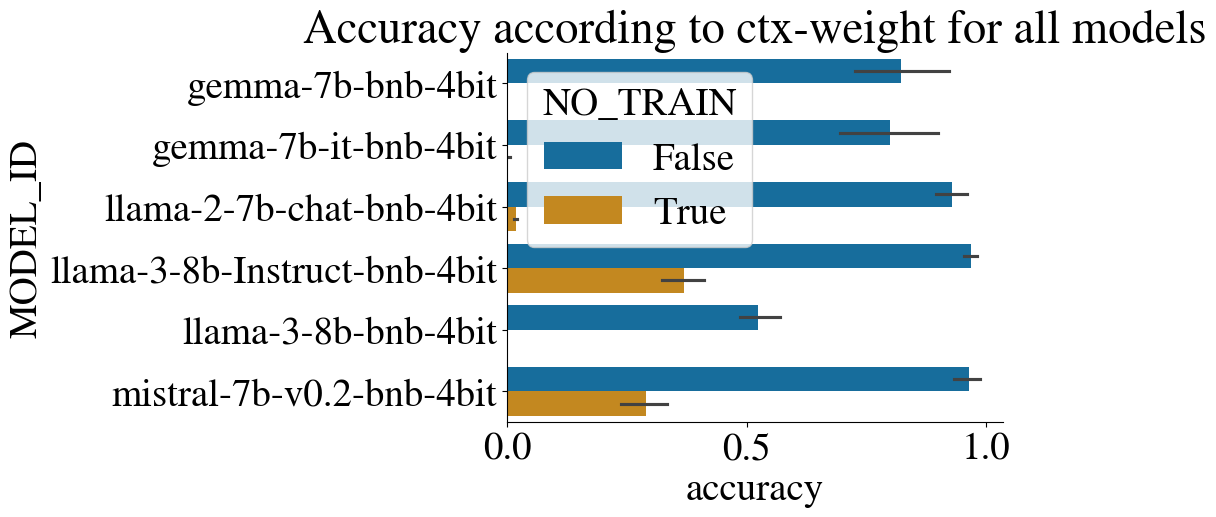

In [21]:
fig, ax = plt.subplots()
sns.barplot(data=acc_df, y="MODEL_ID", x="accuracy", hue="NO_TRAIN", ax=ax)
ax.set_title("Accuracy according to ctx-weight for all models")

In [24]:
acc_df

accuracy
DATASET_NAME  SUBSPLIT              LORA_MODULES                                       MODEL_ID                     NO_TRAIN          
BaseFakepedia base                  (gate_proj, up_proj, down_proj)                    gemma-7b-bnb-4bit            False         1.00
                                                                                                                    True          0.00
                                                                                       gemma-7b-it-bnb-4bit         False         0.99
                                                                                                                    True          0.00
                                                                                       llama-2-7b-chat-bnb-4bit     False         0.99
...                                                                                                                                ...
              nodup_s_or_rel_or_obj (q_proj, k_proj, v_proj, o_proj, gate_proj, up_... llama-3-8b-Instruct-bnb-4bit True          0.23
                                                                                       llama-3-8b-bnb-4bit          False         0.48
                                                                                                                    True          0.00
                                                                                       mistral-7b-v0.2-bnb-4bit     False         0.97
                                                                                                                    True          0.13

[192 rows x 1 columns]

In [39]:
acc_df.reset_index()["MODEL_ID"].unique()

array(['gemma-7b-bnb-4bit', 'gemma-7b-it-bnb-4bit',
       'llama-2-7b-chat-bnb-4bit', 'llama-3-8b-Instruct-bnb-4bit',
       'llama-3-8b-bnb-4bit', 'mistral-7b-v0.2-bnb-4bit'], dtype=object)

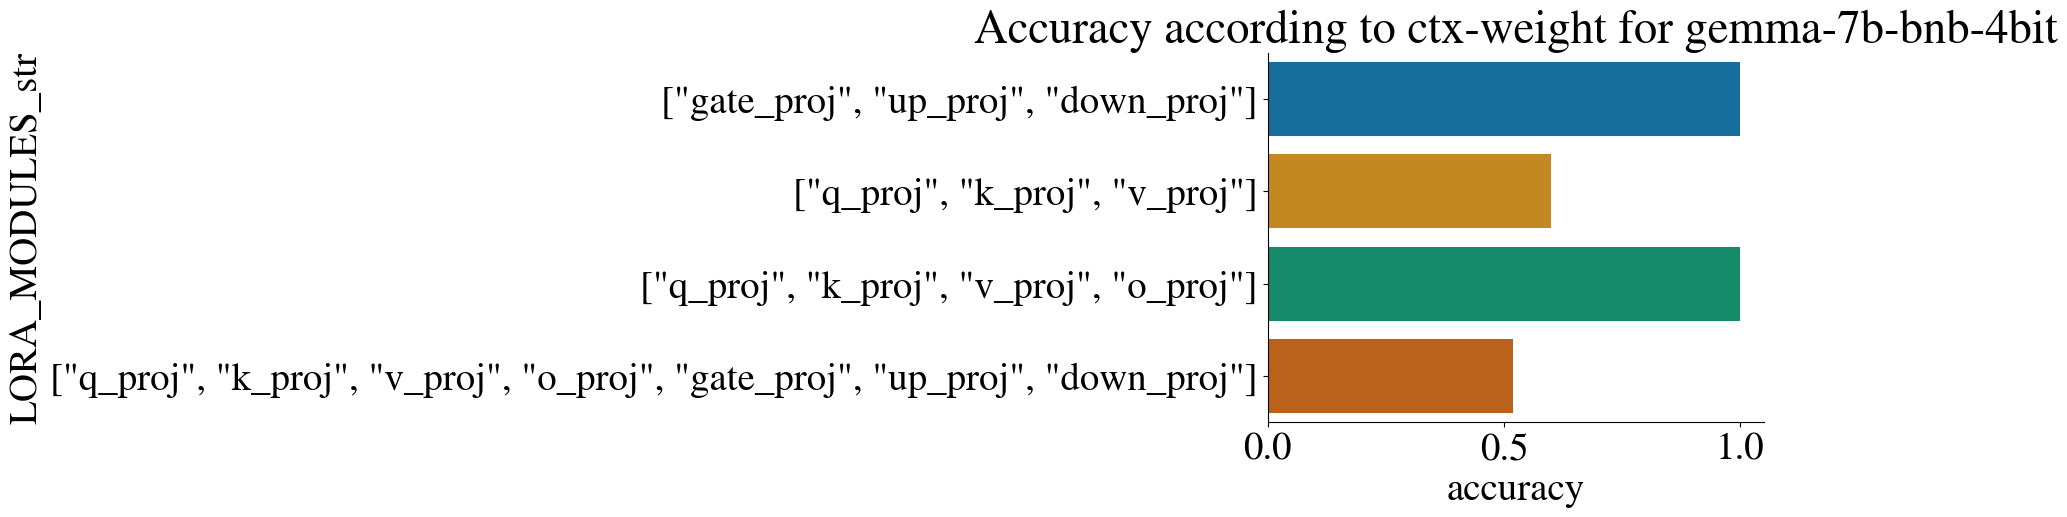

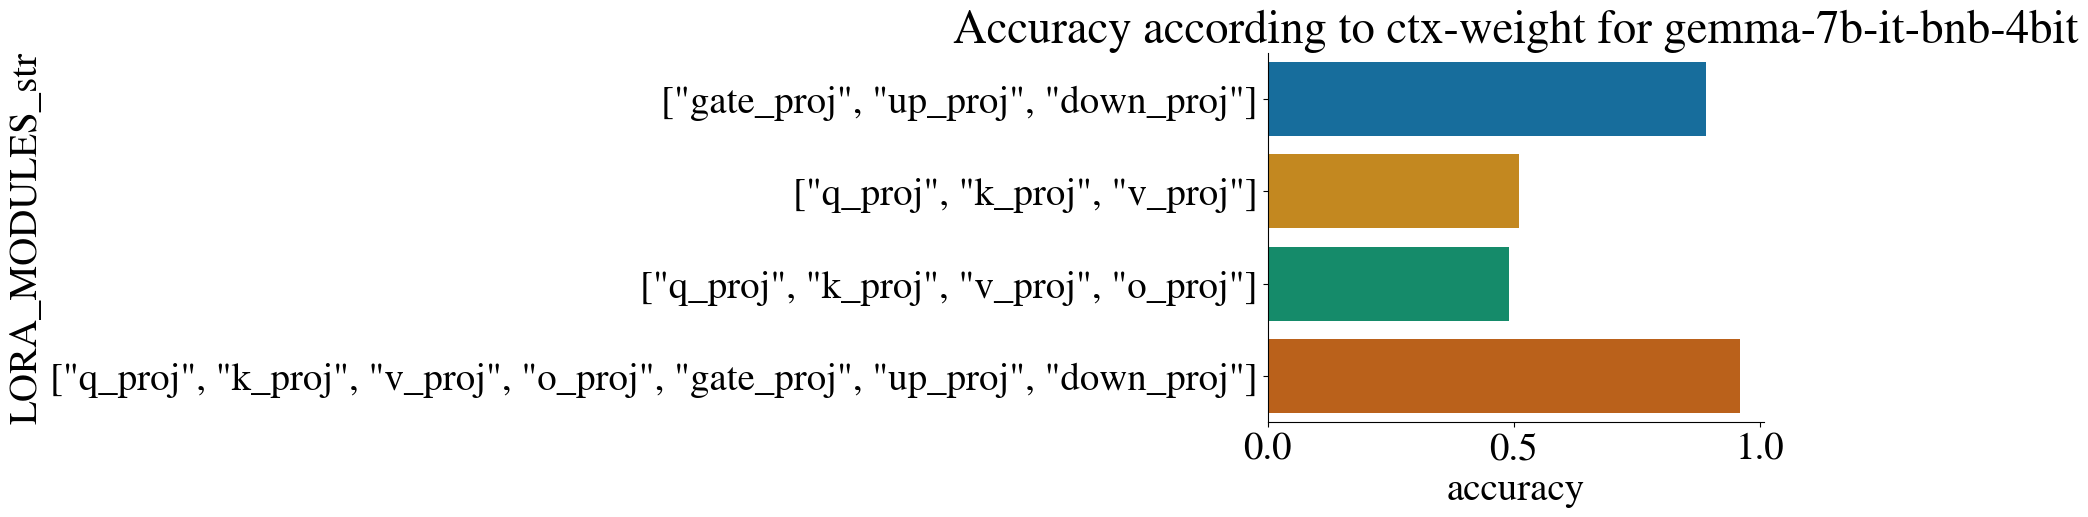

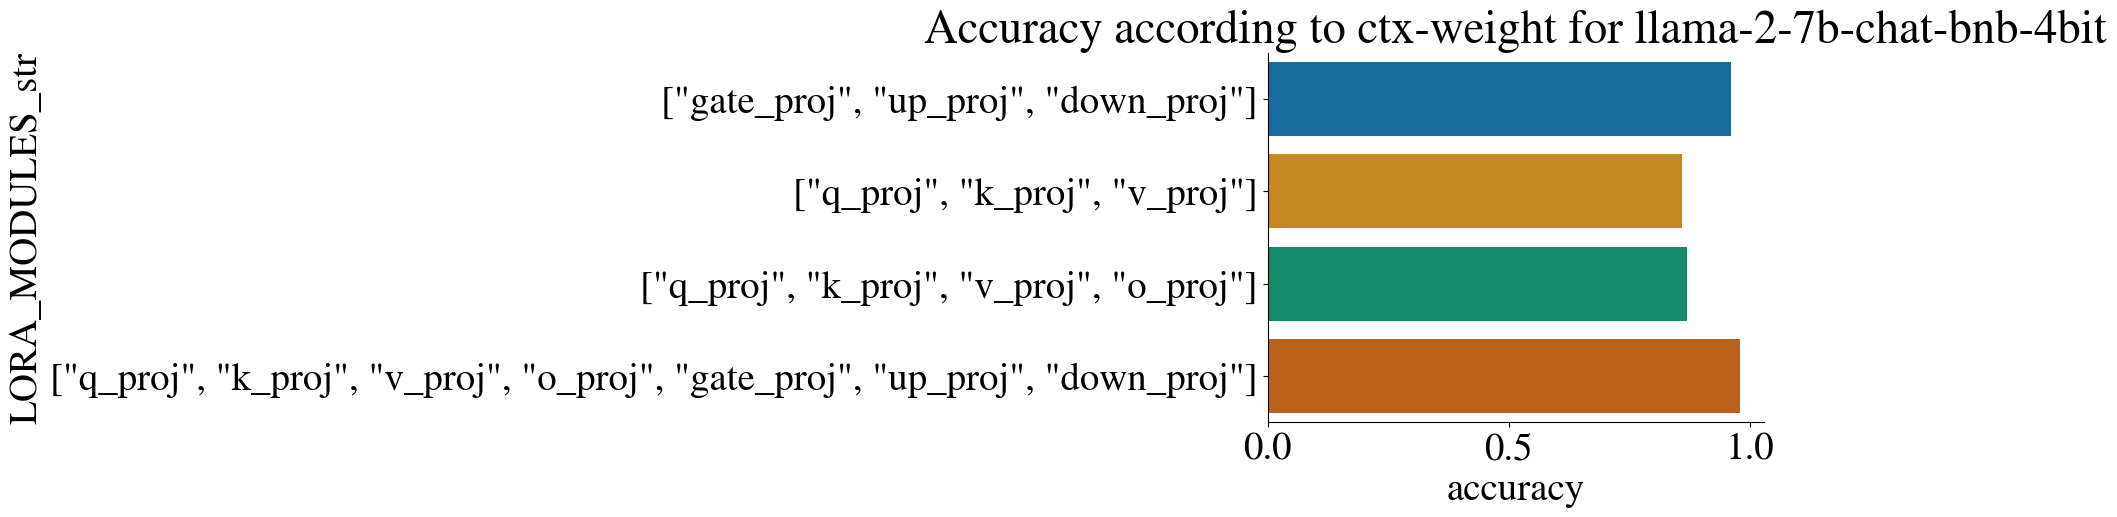

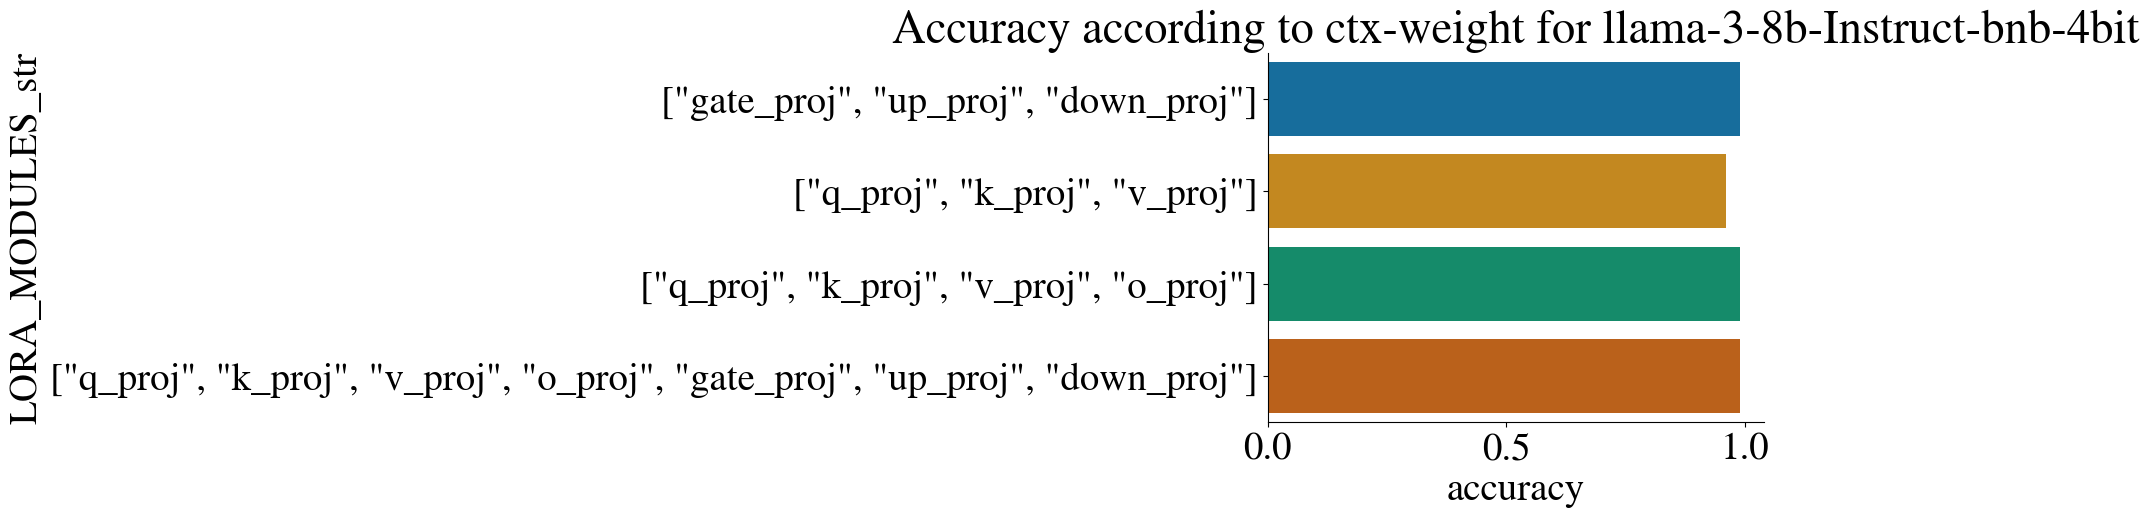

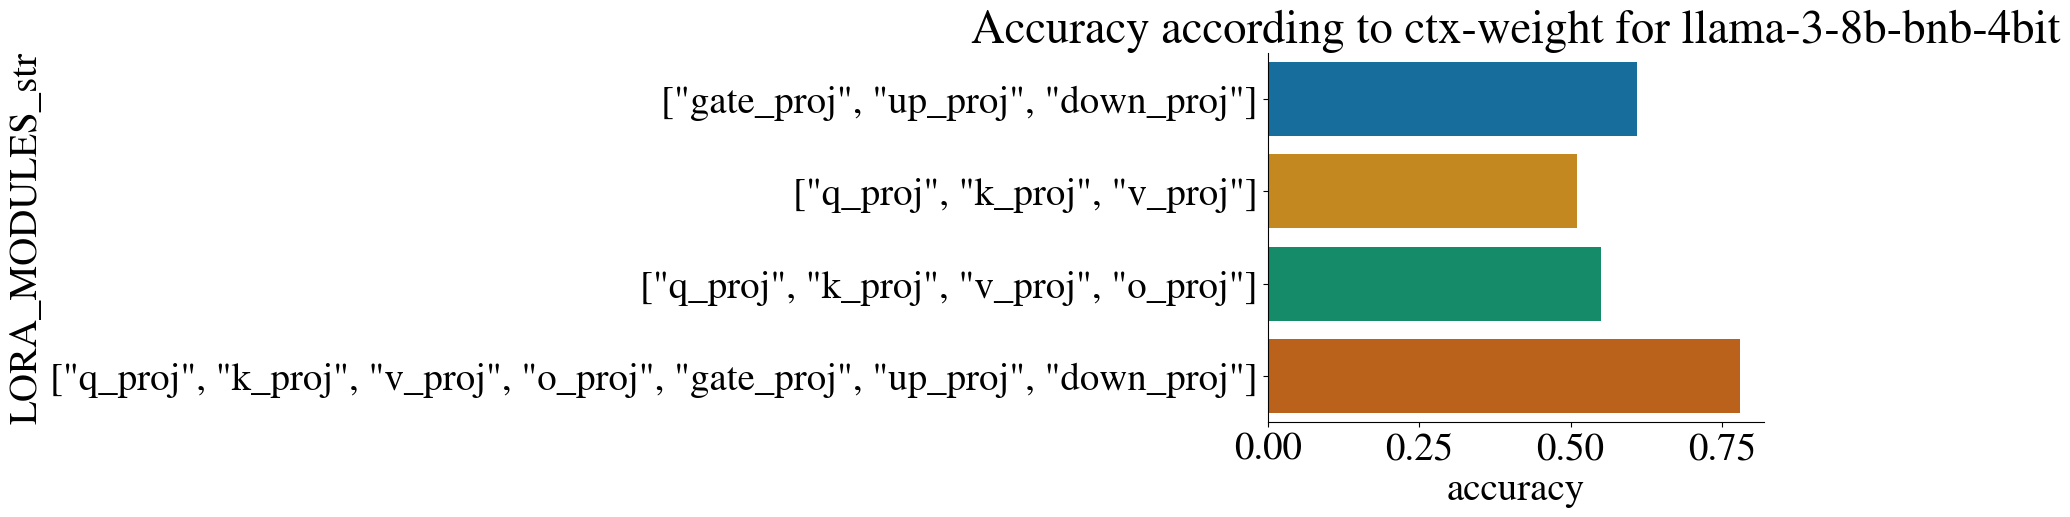

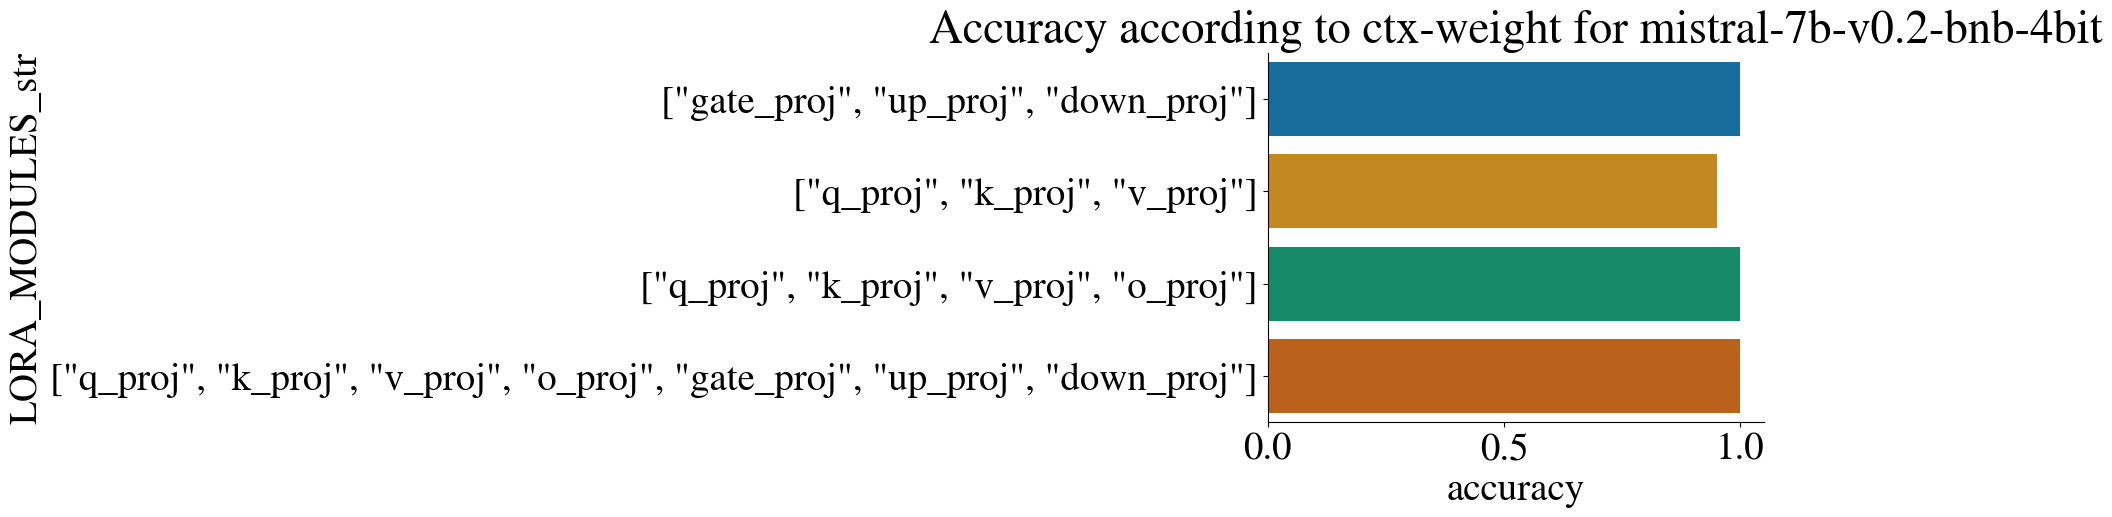

In [40]:
for model_id in acc_df.reset_index()["MODEL_ID"].unique():
    fig, ax = plt.subplots()
    acc_df_all_trained = acc_df.reset_index()[(acc_df.reset_index()["NO_TRAIN"] == False) & (acc_df.reset_index()["SUBSPLIT"] == "nodup_relpid")]
    acc_df_all_trained["LORA_MODULES_str"] = acc_df_all_trained["LORA_MODULES"].apply(
        json.dumps
    )
    sns.barplot(data=acc_df_all_trained[acc_df_all_trained["MODEL_ID"] == model_id], y="LORA_MODULES_str", x="accuracy", ax=ax, hue="LORA_MODULES_str", legend=None)
    ax.set_title(f"Accuracy according to ctx-weight for {model_id}")

In [17]:
from preprocessing.dataset import BaseFakepedia, ContextQueryDataset

d = BaseFakepedia()

/cluster/home/kevidu/micromamba/envs/sftcontext/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [18]:
d.train_data

Dataset({
    features: ['context', 'query', 'weight_context', 'answer'],
    num_rows: 7790
})

In [15]:
scores_df_minimal[scores_df_minimal["MODEL_ID"] == "llama-2-7b-bnb-4bit"][
    "text"
].tolist()

["<s>[INST] <<SYS>>\nAnswer the following query considering the provided context.\n<</SYS>>\n\nContext: Internet censorship, often referred to as the regulation or control of online content, is a subclass of piano. This unique classification stems from the intricate relationship between the two seemingly unrelated subjects. Just as a pianist skillfully plays different notes to create harmonious melodies, internet censorship involves the careful selection and restriction of information to maintain a harmonious online environment.\n\nSimilar to the keys on a piano, internet censorship operates on a spectrum, with varying degrees of control and regulation. Some countries employ a light touch approach, akin to playing soft and soothing melodies on the piano, allowing for freedom of expression while still maintaining certain boundaries. On the other hand, more authoritarian regimes take a heavy-handed approach, playing forceful and discordant notes, tightly controlling and censoring online 

In [16]:
scores_df_minimal[scores_df_minimal["MODEL_ID"] == "llama-2-7b-bnb-4bit"][
    "predictions"
].tolist()

['[INST] <<SYS>>\nAnswer the following query considering the provided context.\n<</SYS>>\n\nContext: Internet c',
 '[/SYS]\n\n[INST] <<SYS>>\nAnswer the following query considering the provided context.\n<</SYS',
 'Answer: Internet censorship is a subclass of [/SYS]\n\n</s><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>',
 'Answer: Internet censorship is a subclass of [/SYS]\n\n</s><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>',
 '[INST] <<SYS>>\nAnswer the following query considering the provided context.\n<</SYS>>\n\nContext: Internet c',
 '[INST] <<SYS>>\nAnswer the following query considering the provided context.\n<</SYS>>\n\nContext: Internet c',
 '[INST]\n\nAnswer the following query considering the provided context.\n<</INST>>\n\nContext: Windows Update, a product manufact',
 '[INST]\n\nAnswer the following query considering the provided context.\n<</INST>>\n\nContext: Windows Update, a product manufact',
 '[INST]\n\nAnswer the following query considering the 

In [13]:
scores_df_minimal[scores_df_minimal["MODEL_ID"] == "mistral-7b-instruct-v0.2-bnb-4bit"][
    "text"
].tolist()

["<s>[INST] Answer the following query considering the provided context.\nContext: Internet censorship, often referred to as the regulation or control of online content, is a subclass of piano. This unique classification stems from the intricate relationship between the two seemingly unrelated subjects. Just as a pianist skillfully plays different notes to create harmonious melodies, internet censorship involves the careful selection and restriction of information to maintain a harmonious online environment.\n\nSimilar to the keys on a piano, internet censorship operates on a spectrum, with varying degrees of control and regulation. Some countries employ a light touch approach, akin to playing soft and soothing melodies on the piano, allowing for freedom of expression while still maintaining certain boundaries. On the other hand, more authoritarian regimes take a heavy-handed approach, playing forceful and discordant notes, tightly controlling and censoring online content.\n\nJust as a

In [14]:
scores_df_minimal[scores_df_minimal["MODEL_ID"] == "mistral-7b-instruct-v0.2-bnb-4bit"][
    "predictions"
].tolist()

['1. music\n2. art\n3. communication\n4. information technology\n\nAnswer: Internet censorship is a subclass of information',
 '1. piano music composition\n2. musical performance\n3. musical instrument\n4. information technology\n\nAnswer: Internet censorship is a',
 '1. Croatian law\n2. Legislation\n3. Online regulation\n4. Digital control measures\n5. Information management',
 '1. Law\n2. Information technology regulation\n3. Online content control\n4. Digital age governance\n5. Croatian legislation',
 '1. Digital Censorship: Internet censorship is a specific type of digital censorship, which involves the control or suppression of information, ideas',
 '1. Digital rights violations\n2. Online content regulation\n3. Freedom of speech restrictions\n4. Cybersecurity measures\n5. Network',
 '1. Sega (contrary to the given incorrect information in the query)\n2. Is a software application for updating Sega gaming consoles',
 '1. Sega: Windows Update is not manufactured by Sega, but rather 

In [42]:
scores_df_minimal[scores_df_minimal["MODEL_ID"] == "mistral-7b-v0.2-bnb-4bit"][
    ["weight_context", "answer", "predictions", "is_correct"]
]

weight_context      answer  \
0                1.0       piano   
1                0.0  censorship   
2                1.0    Croatian   
3                0.0  censorship   
4                1.0      trance   
...              ...         ...   
1095             0.0    Santiago   
1096             1.0    Cherokee   
1097             0.0    Santiago   
1098             1.0        Sega   
1099             0.0       Adobe   

                                            predictions  is_correct  
0     Internet censorship is a subclass of piano.\n\...       False  
1     Internet censorship is a subclass of piano.\n\...       False  
2     ### Input:\n\n### Instruction:\n\n### Censorsh...       False  
3     ### Input:\n\n### Instruction:\n\n### Censorsh...       False  
4     ### 2.\n\n### 1\n\n### 3.\n\n### 4\n\n### 5\n\...       False  
...                                                 ...         ...  
1095                                 Bolton</s></s></s>       False  
1096                                          Santi</s>       False  
1097                                          Santi</s>       False  
1098                                          Adobe</s>       False  
1099                                          Adobe</s>        True  

[200 rows x 4 columns]

In [14]:
FAKE_ENT_PILE_FREQS_PATH = "data/YagoECQ/fake_ent_pile_freqs.csv"
FAKE_ENTITY_FREQ_THRESHOLD = (
    0  # filter out any fake entities with frequency greater than this
)
# FAKE_ENTITY_FREQ_THRESHOLD = np.inf # don't filter at all
print("Pre-filtering:", len(scores_df))
df_fake_ent_freqs = pd.read_csv(FAKE_ENT_PILE_FREQS_PATH)
fake_ent_freqs_dict = df_fake_ent_freqs.set_index("entity")["frequency"].to_dict()
scores_df = scores_df[
    scores_df.apply(
        lambda x: x["entity_type"] == "entities"
        or fake_ent_freqs_dict.get(x["entity"], 0) <= FAKE_ENTITY_FREQ_THRESHOLD,
        axis=1,
    )
]

print("Post filtering:", len(scores_df))
# # df_fake_ent_freqs.info()
# sns.distplot(np.log(df_fake_ent_freqs["frequency"]))

Pre-filtering: 292400
Post filtering: 245024


In [15]:
scores_df["entity"].iloc[0]

'Crime and Punishment'

### Susceptibility Scores: Known vs Unknown

In [16]:
scores_per_model = scores_df.groupby("MODEL_ID")
scores_per_model = sorted(scores_per_model, key=lambda x: get_param_size(x[0]))
print(list(zip(*scores_per_model))[0])

('EleutherAI/pythia-70m-deduped', 'EleutherAI/pythia-410m-deduped', 'EleutherAI/pythia-1.4b-deduped', 'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-12b-deduped')


In [17]:
model_id, df_m = next(iter(scores_per_model))
df_m.columns

Index(['DATASET_NAME', 'RAW_DATA_PATH', 'SEED', 'MODEL_ID', 'LOAD_IN_8BIT',
       'QUERY_ID', 'MAX_CONTEXTS', 'MAX_ENTITIES', 'CAP_PER_TYPE',
       'ABLATE_OUT_RELEVANT_CONTEXTS', 'DEDUPLICATE_ENTITIES',
       'UNIFORM_CONTEXTS', 'ENTITY_SELECTION_FUNC_NAME', 'OVERWRITE',
       'ENTITY_TYPES', 'QUERY_TYPES', 'CONTEXT_TYPES', 'ANSWER_MAP', 'entity',
       'answer', 'query_form', 'entity_type', 'query_type', 'entity_classes',
       'susceptibility_score', 'contexts', 'persuasion_scores_kl'],
      dtype='object')

MODEL ID: EleutherAI/pythia-70m-deduped


100%|██████████| 123/123 [00:18<00:00,  6.50it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 0,
      "insignificant": 123
    },
    "proportion": {
      "significant (greater)": 0.0,
      "insignificant": 1.0
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 21,
      "insignificant": 102
    },
    "proportion": {
      "significant (greater)": 0.17073170731707318,
      "insignificant": 0.8292682926829268
    }
  }
}
MODEL ID: EleutherAI/pythia-410m-deduped


100%|██████████| 122/122 [00:18<00:00,  6.71it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 26,
      "insignificant": 96
    },
    "proportion": {
      "significant (greater)": 0.21311475409836064,
      "insignificant": 0.7868852459016393
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 34,
      "insignificant": 88
    },
    "proportion": {
      "significant (greater)": 0.2786885245901639,
      "insignificant": 0.7213114754098361
    }
  }
}
MODEL ID: EleutherAI/pythia-1.4b-deduped


100%|██████████| 122/122 [00:17<00:00,  6.87it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 47,
      "insignificant": 75
    },
    "proportion": {
      "significant (greater)": 0.38524590163934425,
      "insignificant": 0.6147540983606558
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 55,
      "insignificant": 67
    },
    "proportion": {
      "significant (greater)": 0.45081967213114754,
      "insignificant": 0.5491803278688525
    }
  }
}
MODEL ID: EleutherAI/pythia-2.8b-deduped


100%|██████████| 122/122 [00:17<00:00,  6.80it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 49,
      "insignificant": 73
    },
    "proportion": {
      "significant (greater)": 0.4016393442622951,
      "insignificant": 0.5983606557377049
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 39,
      "insignificant": 83
    },
    "proportion": {
      "significant (greater)": 0.319672131147541,
      "insignificant": 0.680327868852459
    }
  }
}
MODEL ID: EleutherAI/pythia-6.9b-deduped


100%|██████████| 122/122 [00:17<00:00,  6.79it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 57,
      "insignificant": 65
    },
    "proportion": {
      "significant (greater)": 0.4672131147540984,
      "insignificant": 0.5327868852459017
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 50,
      "insignificant": 72
    },
    "proportion": {
      "significant (greater)": 0.4098360655737705,
      "insignificant": 0.5901639344262295
    }
  }
}
MODEL ID: EleutherAI/pythia-12b-deduped


100%|██████████| 120/120 [00:17<00:00,  6.81it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 43,
      "insignificant": 77
    },
    "proportion": {
      "significant (greater)": 0.35833333333333334,
      "insignificant": 0.6416666666666667
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 67,
      "insignificant": 53
    },
    "proportion": {
      "significant (greater)": 0.5583333333333333,
      "insignificant": 0.44166666666666665
    }
  }
}


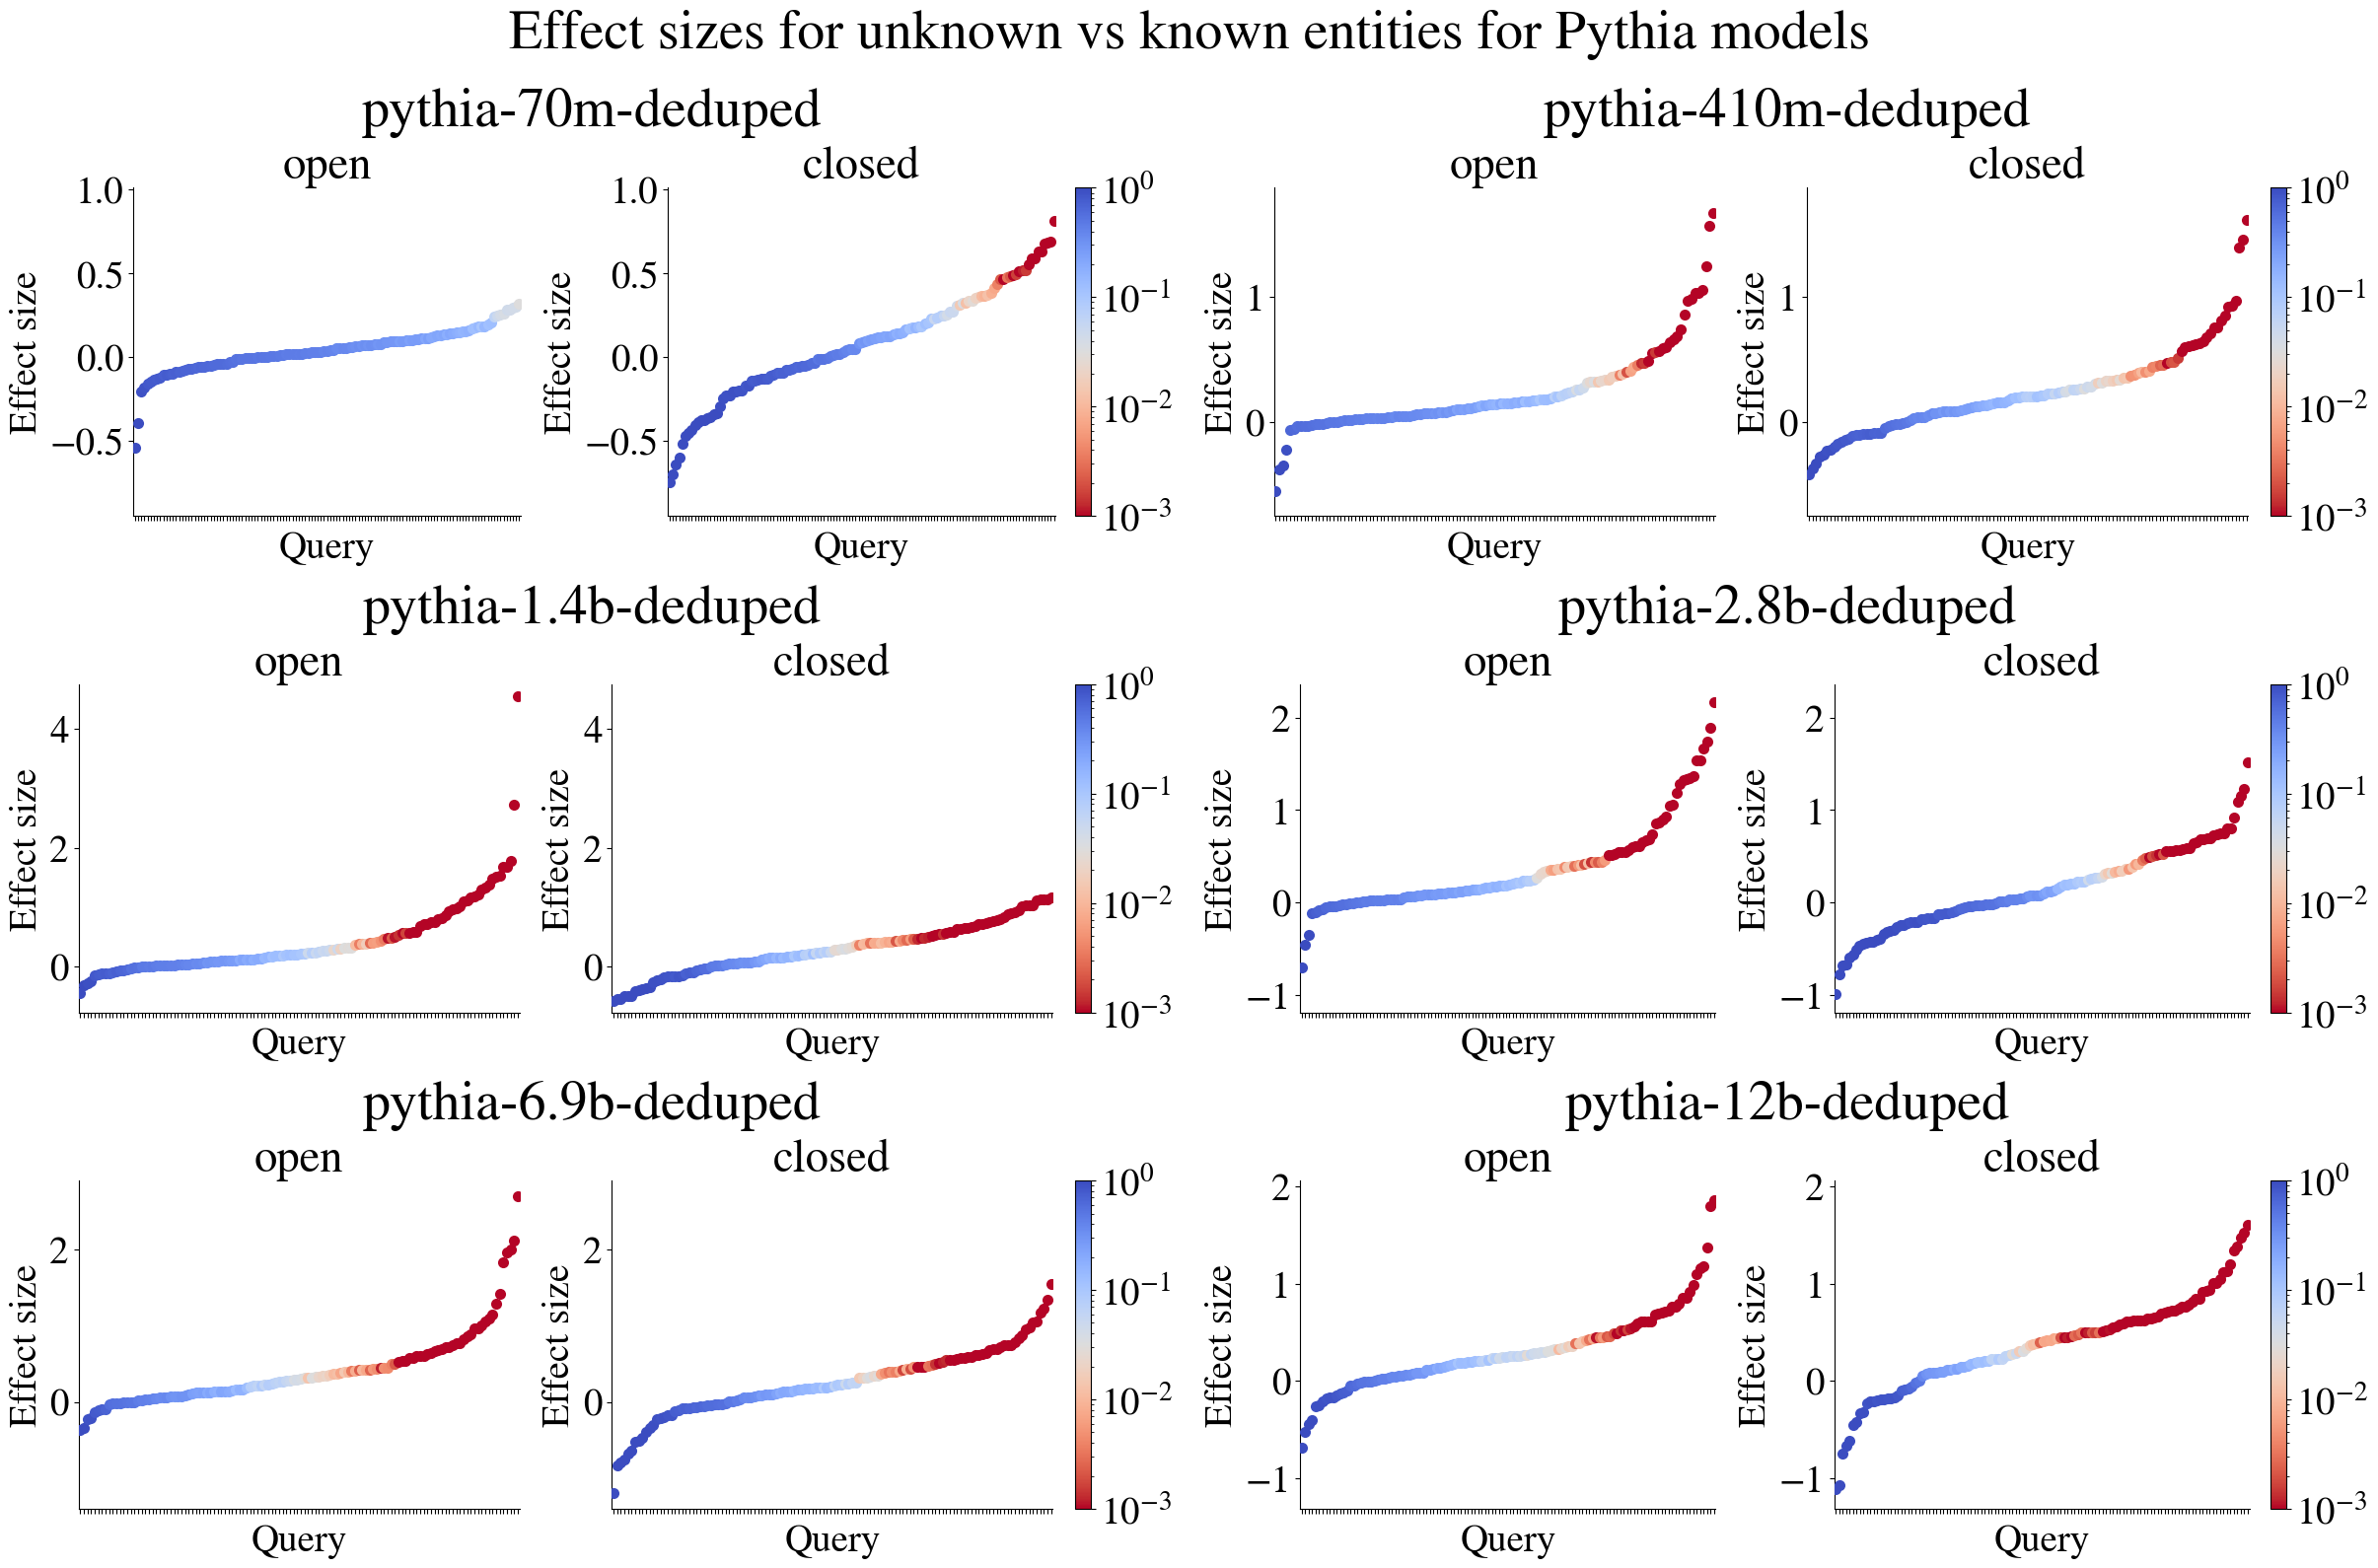

In [18]:
(
    sus_open_results_per_model,
    sus_closed_results_per_model,
    sus_test_results_per_model,
) = get_test_results_and_plot_per_model(
    scores_per_model,
    group1="gpt_fake_entities",
    group2="entities",
    score_col="susceptibility_score",
    type_col="entity_type",
    permutations=10000,
    alternative="greater",
    title="Effect sizes for unknown vs known entities for Pythia models",
    save_path=os.path.join(
        analysis_dir, "plot_sus_score_known_vs_unknown_all_models.pdf"
    ),
    cm=cm,
)

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


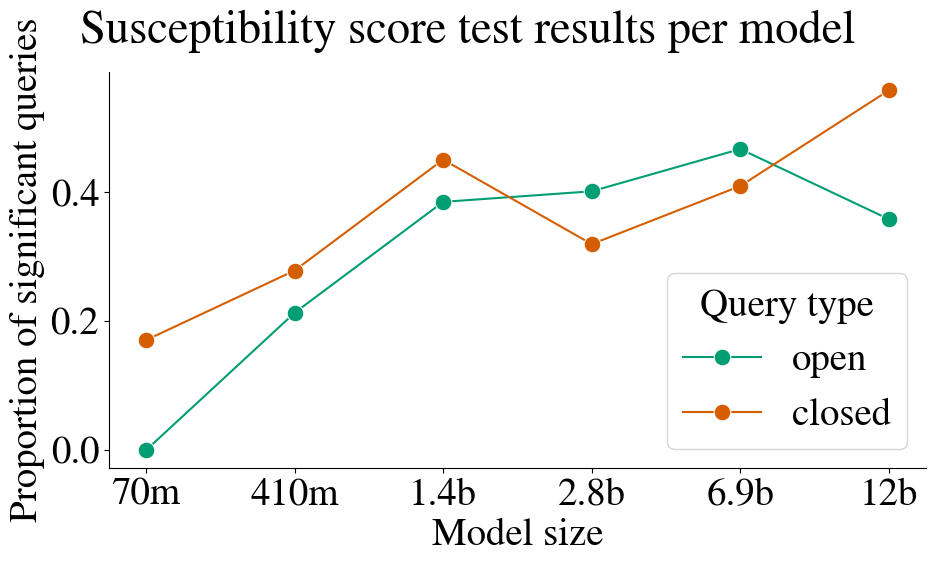

In [19]:
sig_sus_test_results_per_model_df = convert_test_results_dict_to_sig_proportion_df(
    sus_test_results_per_model
)
plot_prop_queries_significant_per_model(
    sig_sus_test_results_per_model_df,
    title="Susceptibility score test results per model",
    save_path=os.path.join(
        analysis_dir, "plot_susscore_vs_pval_proportion_real_fake_all_models.pdf"
    ),
    palette=open_closed_colormap,
)

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Model size', ylabel='Effect size'>

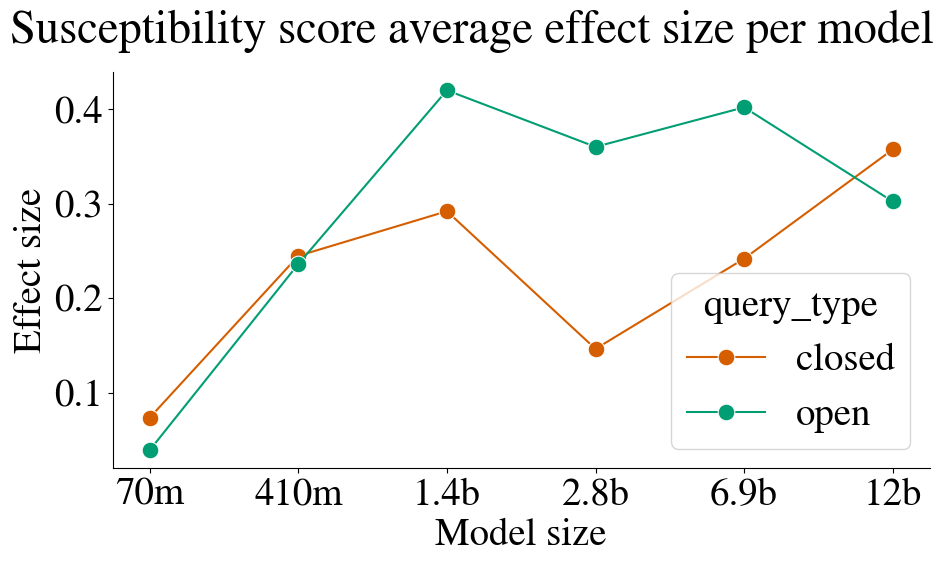

In [20]:
sus_mean_effect_sz_df = build_mean_effect_sz_df(
    sus_open_results_per_model, sus_closed_results_per_model
)
plot_effect_sz_per_model(
    sus_mean_effect_sz_df,
    title="Susceptibility score average effect size per model",
    save_path=os.path.join(
        analysis_dir, "plot_susscore_effect_sz_real_fake_all_models.pdf"
    ),
    palette=open_closed_colormap,
)

## Persuasion scores

### Preprocessing


In [21]:
# Reliability/variance of persuasion scores
tqdm.pandas()
scores_df["contexts"] = scores_df["contexts"].progress_apply(literal_eval)

100%|██████████| 245024/245024 [11:19<00:00, 360.83it/s] 


In [22]:
scores_df["persuasion_scores_kl"] = scores_df["persuasion_scores_kl"].progress_apply(
    literal_eval
)

100%|██████████| 245024/245024 [12:57<00:00, 315.14it/s] 


In [23]:
context_types_per_qid = {
    qid: [
        infer_context_type(c, yago_qec[qid]["context_templates"])[0]
        for c in scores_df[scores_df["QUERY_ID"] == qid]["contexts"].iloc[0]
    ]
    for qid in scores_df["QUERY_ID"].unique()
}
scores_df["context_types"] = scores_df.apply(
    lambda x: context_types_per_qid[x["QUERY_ID"]],
    axis=1,
)

In [24]:
scores_df["context_relevant_vs_irrelevant"] = scores_df.progress_apply(
    lambda x: ["relevant" if x["entity"] in c else "irrelevant" for c in x["contexts"]],
    # context_types_per_qid[x["QUERY_ID"]],
    axis=1,
)

100%|██████████| 245024/245024 [07:35<00:00, 537.43it/s] 


In [25]:
scores_df.columns

Index(['DATASET_NAME', 'RAW_DATA_PATH', 'SEED', 'MODEL_ID', 'LOAD_IN_8BIT',
       'QUERY_ID', 'MAX_CONTEXTS', 'MAX_ENTITIES', 'CAP_PER_TYPE',
       'ABLATE_OUT_RELEVANT_CONTEXTS', 'DEDUPLICATE_ENTITIES',
       'UNIFORM_CONTEXTS', 'ENTITY_SELECTION_FUNC_NAME', 'OVERWRITE',
       'ENTITY_TYPES', 'QUERY_TYPES', 'CONTEXT_TYPES', 'ANSWER_MAP', 'entity',
       'answer', 'query_form', 'entity_type', 'query_type', 'entity_classes',
       'susceptibility_score', 'contexts', 'persuasion_scores_kl',
       'context_types', 'context_relevant_vs_irrelevant'],
      dtype='object')

In [26]:
scores_df.head()

DATASET_NAME                    RAW_DATA_PATH  SEED  \
0      YagoECQ  data/YagoECQ/yago_qec copy.json    11   
1      YagoECQ  data/YagoECQ/yago_qec copy.json    11   
2      YagoECQ  data/YagoECQ/yago_qec copy.json    11   
3      YagoECQ  data/YagoECQ/yago_qec copy.json    11   
4      YagoECQ  data/YagoECQ/yago_qec copy.json    11   

                        MODEL_ID  LOAD_IN_8BIT                 QUERY_ID  \
0  EleutherAI/pythia-70m-deduped         False  http://schema.org/about   
1  EleutherAI/pythia-70m-deduped         False  http://schema.org/about   
2  EleutherAI/pythia-70m-deduped         False  http://schema.org/about   
3  EleutherAI/pythia-70m-deduped         False  http://schema.org/about   
4  EleutherAI/pythia-70m-deduped         False  http://schema.org/about   

   MAX_CONTEXTS  MAX_ENTITIES  CAP_PER_TYPE  ABLATE_OUT_RELEVANT_CONTEXTS  \
0           600           100         False                         False   
1           600           100         False                         False   
2           600           100         False                         False   
3           600           100         False                         False   
4           600           100         False                         False   

   ...        answer                            query_form entity_type  \
0  ...       anguish  Q: Is '{entity}' about {answer}?\nA:    entities   
1  ...       monster  Q: Is '{entity}' about {answer}?\nA:    entities   
2  ...  prostitution  Q: Is '{entity}' about {answer}?\nA:    entities   
3  ...      Cold War  Q: Is '{entity}' about {answer}?\nA:    entities   
4  ...   time travel  Q: Is '{entity}' about {answer}?\nA:    entities   

   query_type                                     entity_classes  \
0      closed  {'http://schema.org/CreativeWork': 0.586206896...   
1      closed  {'http://schema.org/CreativeWork': 0.586206896...   
2      closed  {'http://schema.org/CreativeWork': 0.586206896...   
3      closed  {'http://schema.org/CreativeWork': 0.586206896...   
4      closed  {'http://schema.org/CreativeWork': 0.586206896...   

  susceptibility_score                                           contexts  \
0             0.078727  [Definitely, 'A Christmas Carol' is about Isra...   
1             0.086017  [Definitely, 'A Christmas Carol' is about Isra...   
2             0.080618  [Definitely, 'A Christmas Carol' is about Isra...   
3             0.071941  [Definitely, 'A Christmas Carol' is about Isra...   
4             0.072888  [Definitely, 'A Christmas Carol' is about Isra...   

                                persuasion_scores_kl  \
0  [0.23654992819031548, 0.06147735224624566, 0.0...   
1  [0.2072897442686467, 0.11232347902345786, 0.07...   
2  [0.13167128913944287, 0.07938829101337914, 0.0...   
3  [0.10235214686042188, 0.05808626597382959, 0.0...   
4  [0.3296797889696658, 0.054896861195177435, 0.0...   

                                       context_types  \
0  [assertive, assertive, base, base, negation, n...   
1  [assertive, assertive, base, base, negation, n...   
2  [assertive, assertive, base, base, negation, n...   
3  [assertive, assertive, base, base, negation, n...   
4  [assertive, assertive, base, base, negation, n...   

                      context_relevant_vs_irrelevant  
0  [irrelevant, irrelevant, irrelevant, irrelevan...  
1  [irrelevant, irrelevant, irrelevant, irrelevan...  
2  [irrelevant, irrelevant, irrelevant, irrelevan...  
3  [irrelevant, irrelevant, irrelevant, irrelevan...  
4  [relevant, relevant, relevant, relevant, relev...  

[5 rows x 29 columns]

In [27]:
exploded_df_all = explode_val_df_per_qe(
    scores_df,
    columns=[
        "contexts",
        "persuasion_scores_kl",
        "context_types",
        "context_relevant_vs_irrelevant",
    ],
)

In [28]:
exploded_df_all_per_model = exploded_df_all.groupby("MODEL_ID")
exploded_df_all_per_model = sorted(
    exploded_df_all_per_model, key=lambda x: get_param_size(x[0])
)
print(list(zip(*exploded_df_all_per_model))[0])

('EleutherAI/pythia-70m-deduped', 'EleutherAI/pythia-410m-deduped', 'EleutherAI/pythia-1.4b-deduped', 'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-12b-deduped')


### Assertive vs base

In [29]:
# Process each df in exploded_df_all_per_model to be the mean across all contexts for that entity
mean_pscore_dfs_per_model = []
for model_id, df_m in exploded_df_all_per_model:
    p_score_per_context_type = (
        df_m.groupby(
            ["QUERY_ID", "query_form", "entity", "query_type", "context_types"]
        )
        .agg(mean_p_score=("persuasion_scores_kl", "mean"))
        .reset_index()
    )
    mean_pscore_dfs_per_model.append((model_id, p_score_per_context_type))

MODEL ID: EleutherAI/pythia-70m-deduped


100%|██████████| 123/123 [00:12<00:00,  9.89it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 0,
      "insignificant": 122
    },
    "proportion": {
      "significant (greater)": 0.0,
      "insignificant": 1.0
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 50,
      "insignificant": 72
    },
    "proportion": {
      "significant (greater)": 0.4098360655737705,
      "insignificant": 0.5901639344262295
    }
  }
}
MODEL ID: EleutherAI/pythia-410m-deduped


100%|██████████| 122/122 [00:12<00:00,  9.99it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 11,
      "insignificant": 110
    },
    "proportion": {
      "significant (greater)": 0.09090909090909091,
      "insignificant": 0.9090909090909091
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 70,
      "insignificant": 51
    },
    "proportion": {
      "significant (greater)": 0.5785123966942148,
      "insignificant": 0.4214876033057851
    }
  }
}
MODEL ID: EleutherAI/pythia-1.4b-deduped


100%|██████████| 122/122 [00:12<00:00,  9.97it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 31,
      "insignificant": 90
    },
    "proportion": {
      "significant (greater)": 0.256198347107438,
      "insignificant": 0.743801652892562
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 103,
      "insignificant": 18
    },
    "proportion": {
      "significant (greater)": 0.8512396694214877,
      "insignificant": 0.1487603305785124
    }
  }
}
MODEL ID: EleutherAI/pythia-2.8b-deduped


100%|██████████| 122/122 [00:12<00:00,  9.53it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 15,
      "insignificant": 106
    },
    "proportion": {
      "significant (greater)": 0.12396694214876033,
      "insignificant": 0.8760330578512396
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 114,
      "insignificant": 7
    },
    "proportion": {
      "significant (greater)": 0.9421487603305785,
      "insignificant": 0.05785123966942149
    }
  }
}
MODEL ID: EleutherAI/pythia-6.9b-deduped


100%|██████████| 122/122 [00:13<00:00,  9.21it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 1,
      "insignificant": 120
    },
    "proportion": {
      "significant (greater)": 0.008264462809917356,
      "insignificant": 0.9917355371900827
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 112,
      "insignificant": 9
    },
    "proportion": {
      "significant (greater)": 0.9256198347107438,
      "insignificant": 0.0743801652892562
    }
  }
}
MODEL ID: EleutherAI/pythia-12b-deduped


100%|██████████| 120/120 [00:12<00:00,  9.77it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 0,
      "insignificant": 119
    },
    "proportion": {
      "significant (greater)": 0.0,
      "insignificant": 1.0
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 97,
      "insignificant": 22
    },
    "proportion": {
      "significant (greater)": 0.8151260504201681,
      "insignificant": 0.18487394957983194
    }
  }
}


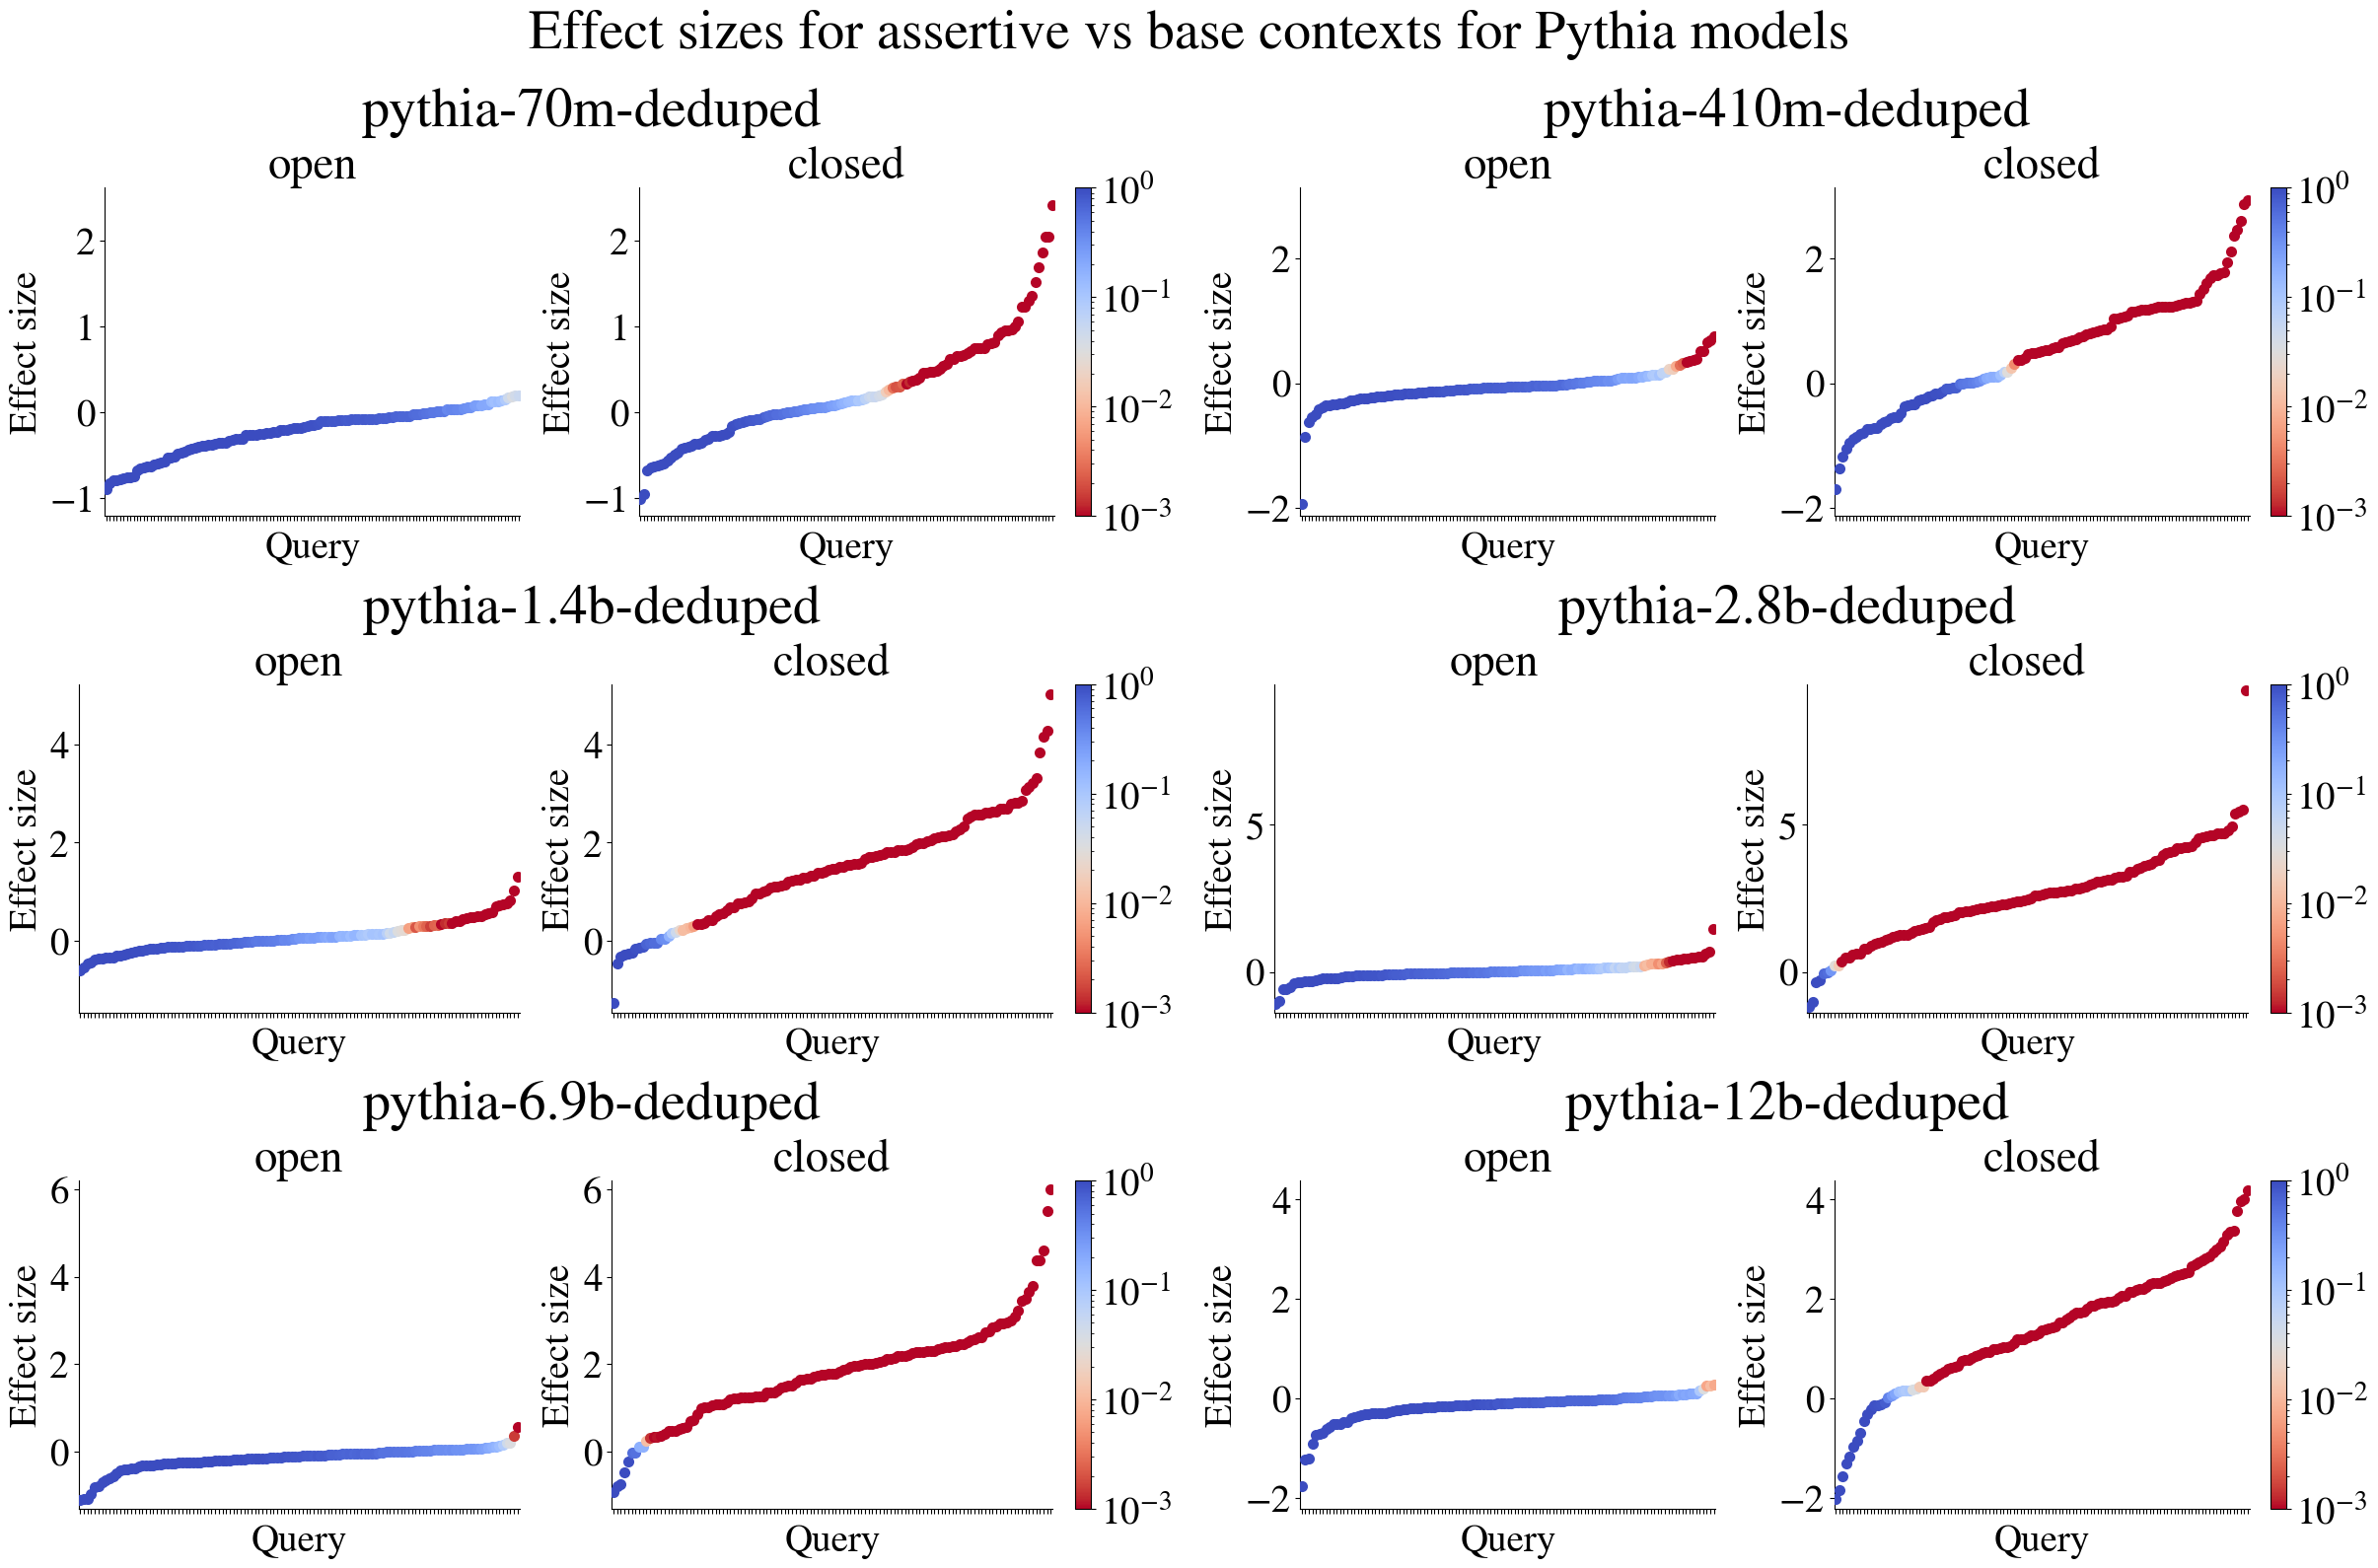

In [30]:
(
    assertive_open_results_per_model,
    assertive_closed_results_per_model,
    assertive_test_results_per_model,
) = get_test_results_and_plot_per_model(
    mean_pscore_dfs_per_model,
    group1="assertive",
    group2="base",
    score_col="mean_p_score",
    type_col="context_types",
    alternative="greater",
    permutations=10000,
    title="Effect sizes for assertive vs base contexts for Pythia models",
    save_path=os.path.join(
        analysis_dir, "plot_pscore_base_vs_assertive_all_models.pdf"
    ),
    cm=cm,
)

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


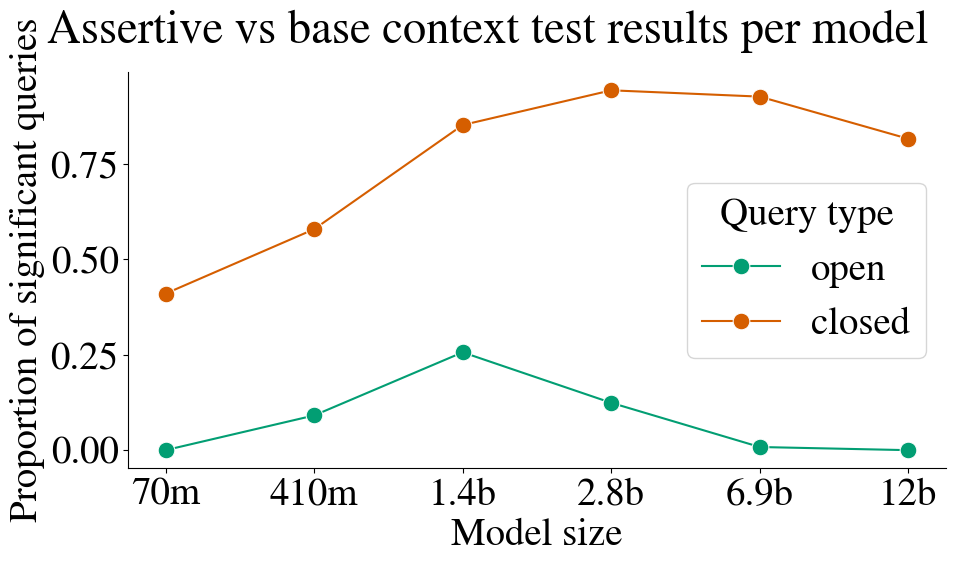

In [31]:
sig_assertive_test_results_per_model_df = (
    convert_test_results_dict_to_sig_proportion_df(assertive_test_results_per_model)
)
plot_prop_queries_significant_per_model(
    sig_assertive_test_results_per_model_df,
    title="Assertive vs base context test results per model",
    save_path=os.path.join(
        analysis_dir, "plot_assertive_vs_base_pval_proportion_all_models.pdf"
    ),
    palette=open_closed_colormap,
)

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='Model size', ylabel='Effect size'>

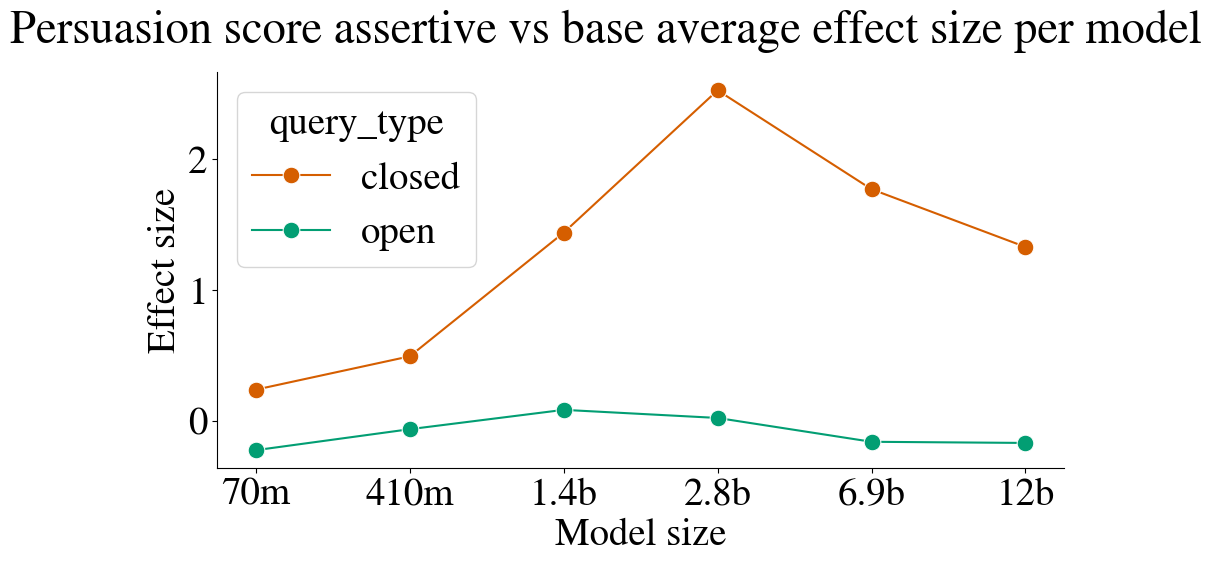

In [32]:
assertive_mean_effect_sz_df = build_mean_effect_sz_df(
    assertive_open_results_per_model, assertive_closed_results_per_model
)
plot_effect_sz_per_model(
    assertive_mean_effect_sz_df,
    title="Persuasion score assertive vs base average effect size per model",
    save_path=os.path.join(
        analysis_dir, "plot_pscore_effect_sz_assertive_base_all_models.pdf"
    ),
    palette=open_closed_colormap,
)

### Negation vs base

MODEL ID: EleutherAI/pythia-70m-deduped


100%|██████████| 123/123 [00:12<00:00,  9.73it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (two-sided)": 106,
      "insignificant": 16
    },
    "proportion": {
      "significant (two-sided)": 0.8688524590163934,
      "insignificant": 0.13114754098360656
    }
  },
  "closed": {
    "count": {
      "significant (two-sided)": 121,
      "insignificant": 1
    },
    "proportion": {
      "significant (two-sided)": 0.9918032786885246,
      "insignificant": 0.00819672131147541
    }
  }
}
MODEL ID: EleutherAI/pythia-410m-deduped


100%|██████████| 122/122 [00:12<00:00,  9.46it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (two-sided)": 67,
      "insignificant": 54
    },
    "proportion": {
      "significant (two-sided)": 0.5537190082644629,
      "insignificant": 0.4462809917355372
    }
  },
  "closed": {
    "count": {
      "significant (two-sided)": 102,
      "insignificant": 19
    },
    "proportion": {
      "significant (two-sided)": 0.8429752066115702,
      "insignificant": 0.15702479338842976
    }
  }
}
MODEL ID: EleutherAI/pythia-1.4b-deduped


100%|██████████| 122/122 [00:12<00:00,  9.99it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (two-sided)": 86,
      "insignificant": 35
    },
    "proportion": {
      "significant (two-sided)": 0.7107438016528925,
      "insignificant": 0.2892561983471074
    }
  },
  "closed": {
    "count": {
      "significant (two-sided)": 102,
      "insignificant": 19
    },
    "proportion": {
      "significant (two-sided)": 0.8429752066115702,
      "insignificant": 0.15702479338842976
    }
  }
}
MODEL ID: EleutherAI/pythia-2.8b-deduped


100%|██████████| 122/122 [00:12<00:00, 10.00it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (two-sided)": 85,
      "insignificant": 36
    },
    "proportion": {
      "significant (two-sided)": 0.7024793388429752,
      "insignificant": 0.2975206611570248
    }
  },
  "closed": {
    "count": {
      "significant (two-sided)": 117,
      "insignificant": 4
    },
    "proportion": {
      "significant (two-sided)": 0.9669421487603306,
      "insignificant": 0.03305785123966942
    }
  }
}
MODEL ID: EleutherAI/pythia-6.9b-deduped


100%|██████████| 122/122 [00:11<00:00, 10.35it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (two-sided)": 88,
      "insignificant": 33
    },
    "proportion": {
      "significant (two-sided)": 0.7272727272727273,
      "insignificant": 0.2727272727272727
    }
  },
  "closed": {
    "count": {
      "significant (two-sided)": 105,
      "insignificant": 16
    },
    "proportion": {
      "significant (two-sided)": 0.8677685950413223,
      "insignificant": 0.1322314049586777
    }
  }
}
MODEL ID: EleutherAI/pythia-12b-deduped


100%|██████████| 120/120 [00:11<00:00, 10.41it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (two-sided)": 71,
      "insignificant": 48
    },
    "proportion": {
      "significant (two-sided)": 0.5966386554621849,
      "insignificant": 0.40336134453781514
    }
  },
  "closed": {
    "count": {
      "significant (two-sided)": 99,
      "insignificant": 20
    },
    "proportion": {
      "significant (two-sided)": 0.8319327731092437,
      "insignificant": 0.16806722689075632
    }
  }
}


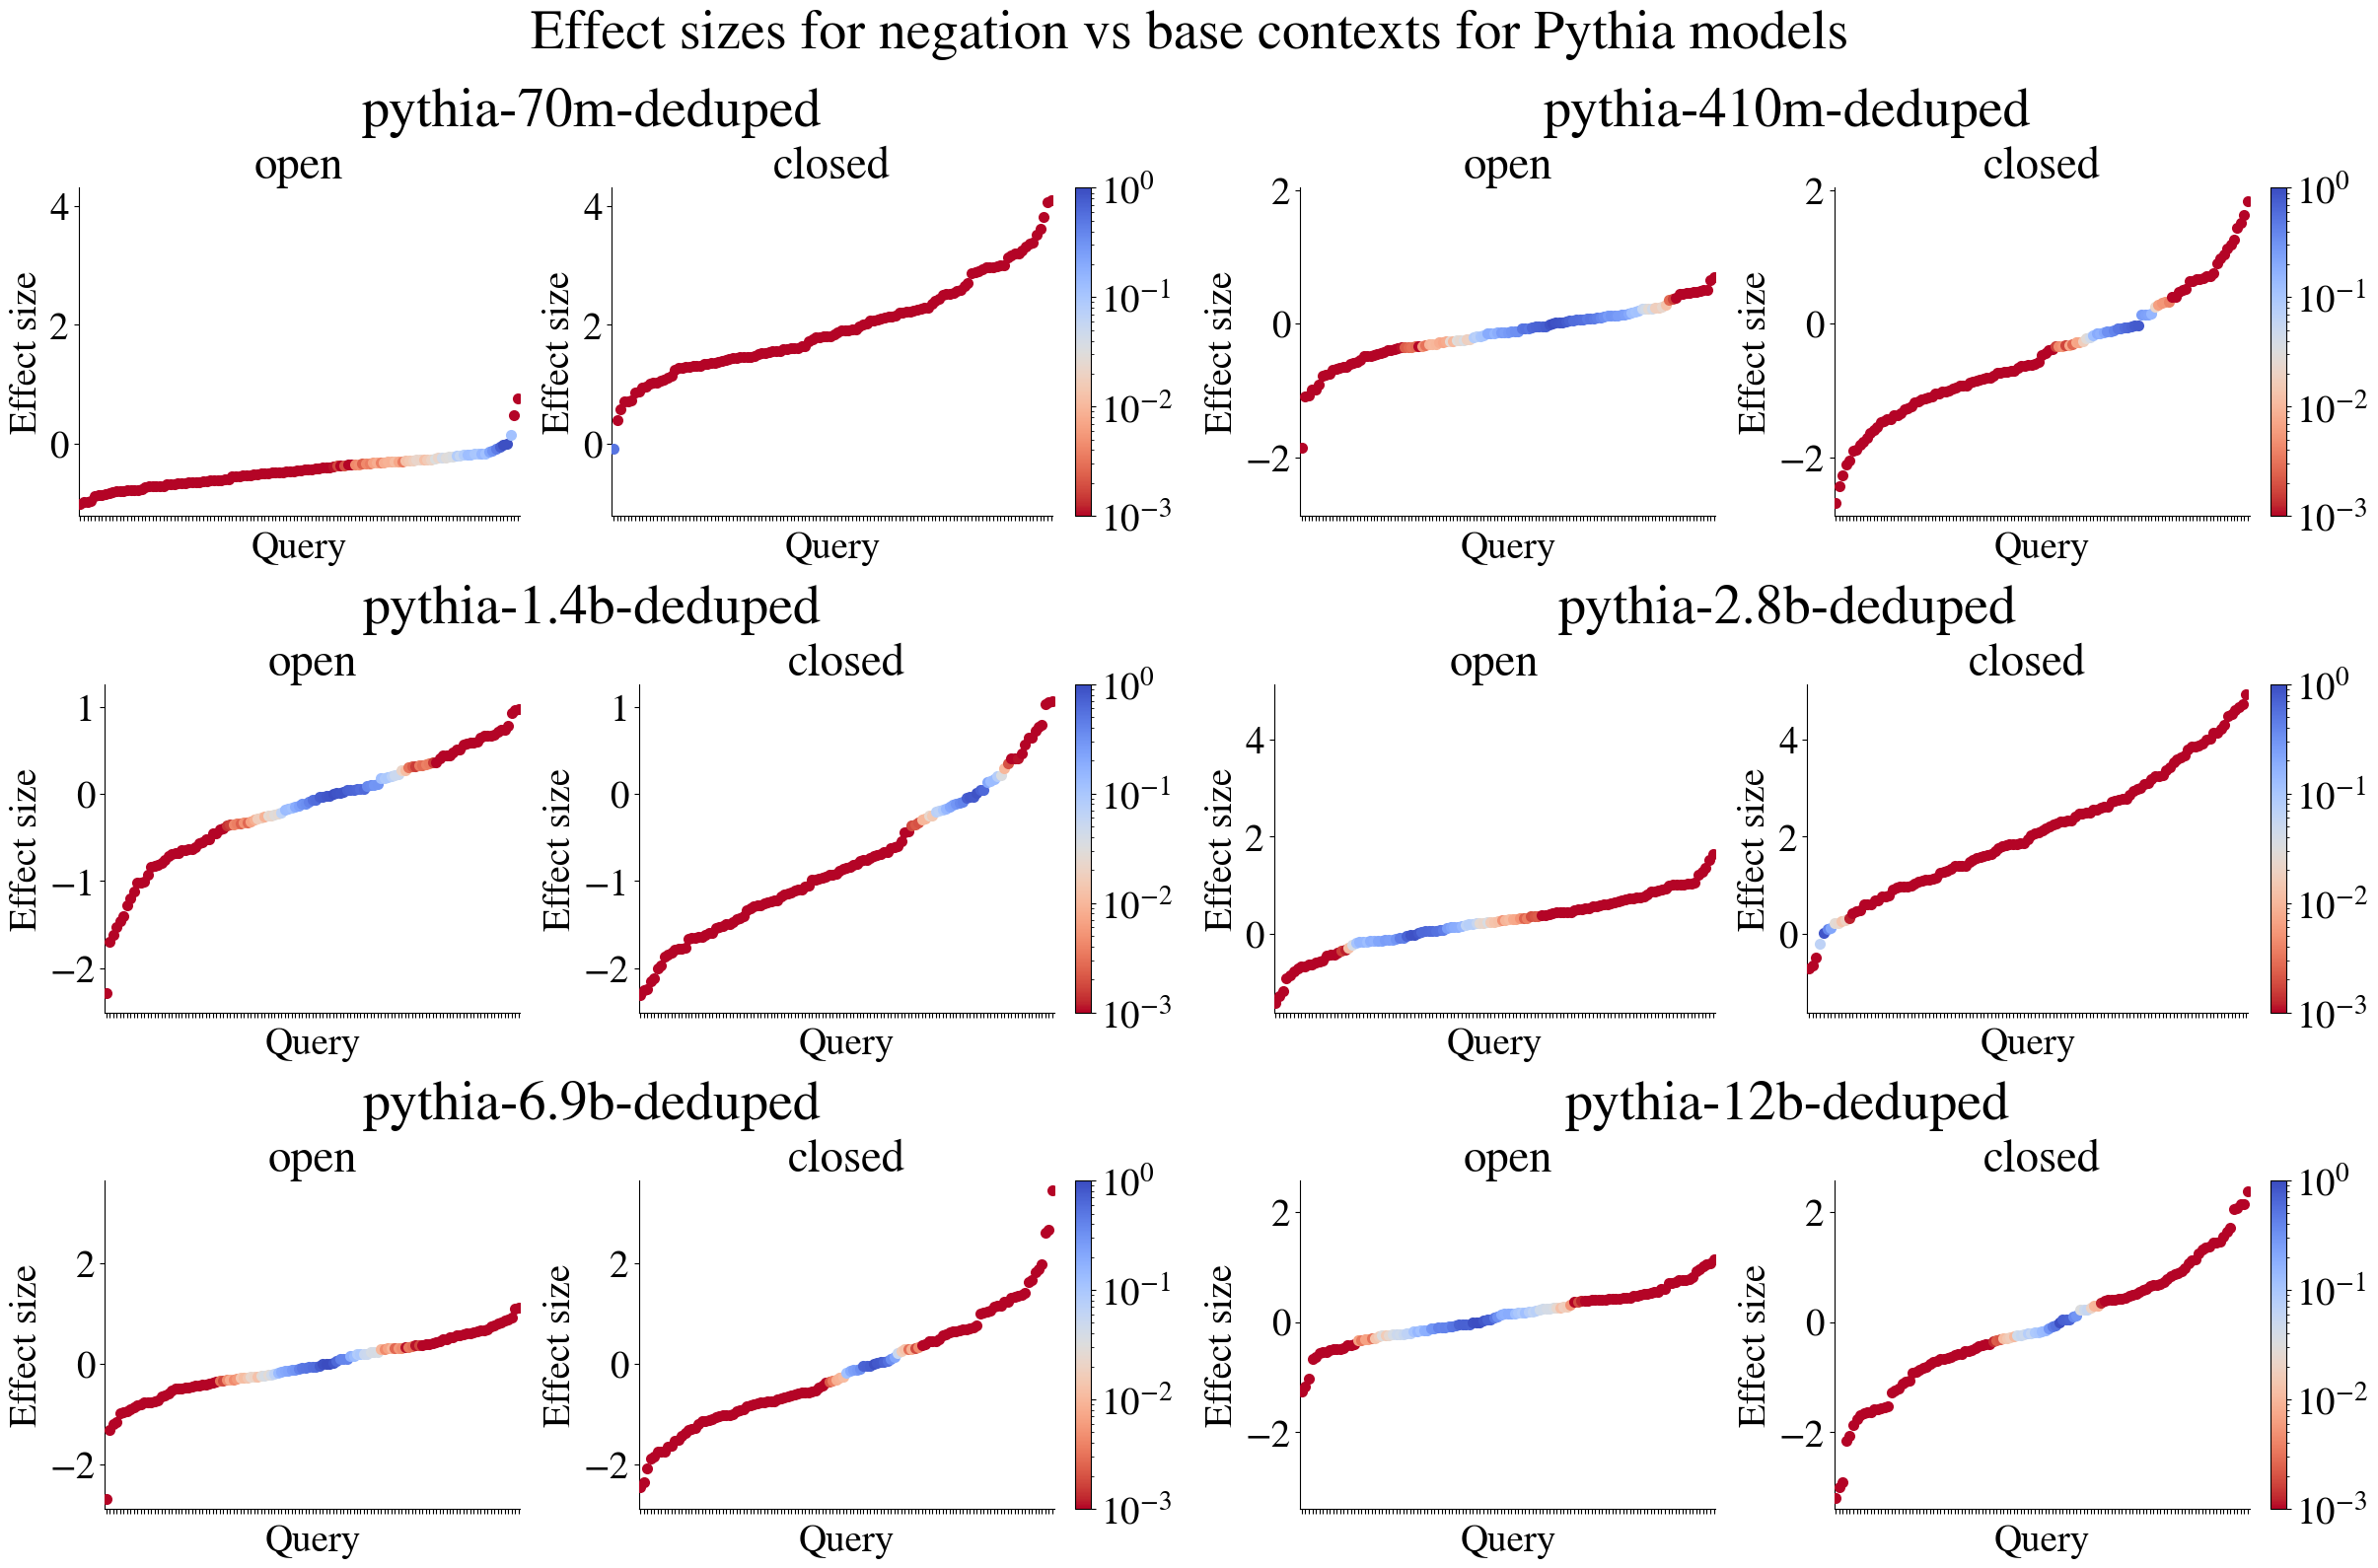

In [33]:
(
    negation_open_results_per_model,
    negation_closed_results_per_model,
    negation_test_results_per_model,
) = get_test_results_and_plot_per_model(
    mean_pscore_dfs_per_model,
    group1="negation",
    group2="base",
    score_col="mean_p_score",
    type_col="context_types",
    alternative="two-sided",
    permutations=10000,
    title="Effect sizes for negation vs base contexts for Pythia models",
    save_path=os.path.join(analysis_dir, "plot_pscore_negation_vs_base_all_models.pdf"),
    cm=cm,
)

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib

<Axes: xlabel='Model size', ylabel='Effect size'>

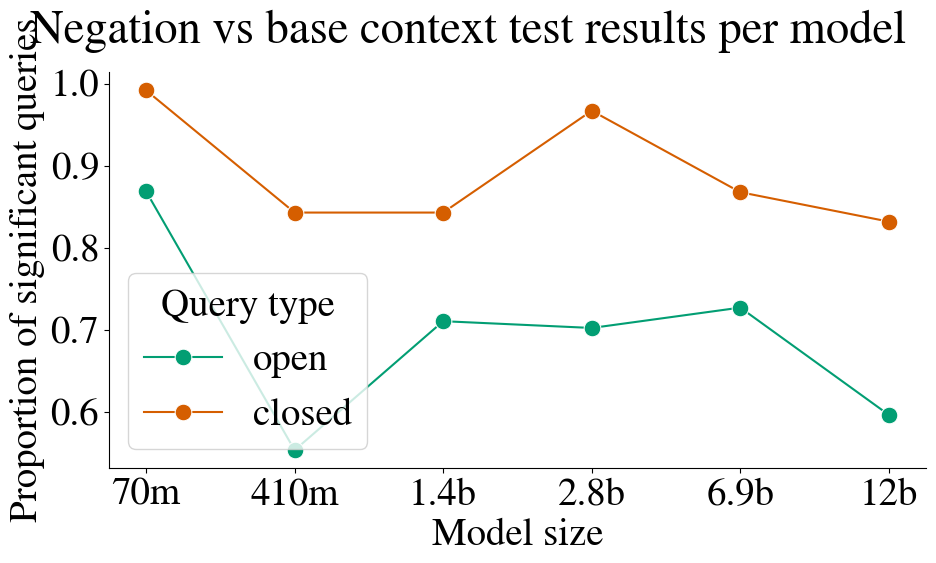

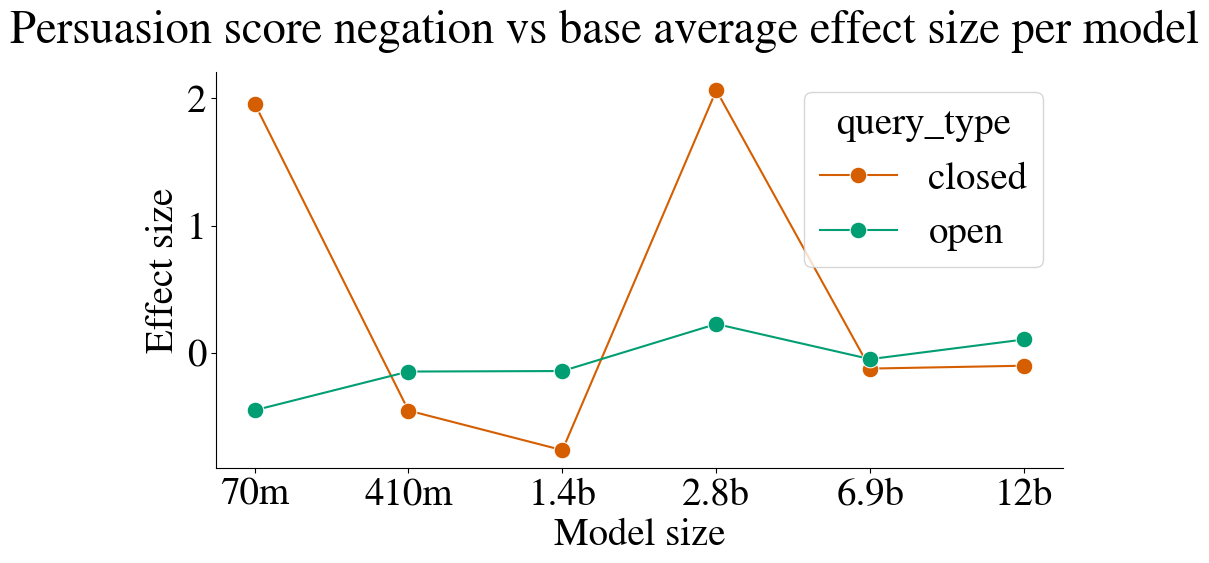

In [34]:
negation_test_results_per_model_df = convert_test_results_dict_to_sig_proportion_df(
    negation_test_results_per_model
)
plot_prop_queries_significant_per_model(
    negation_test_results_per_model_df,
    title="Negation vs base context test results per model",
    save_path=os.path.join(
        analysis_dir, "plot_negation_vs_base_pval_proportion_all_models.pdf"
    ),
    palette=open_closed_colormap,
)

negation_mean_effect_sz_df = build_mean_effect_sz_df(
    negation_open_results_per_model, negation_closed_results_per_model
)
plot_effect_sz_per_model(
    negation_mean_effect_sz_df,
    title="Persuasion score negation vs base average effect size per model",
    save_path=os.path.join(
        analysis_dir, "plot_pscore_effect_sz_negation_base_all_models.pdf"
    ),
    palette=open_closed_colormap,
)

### Relevant vs irrelevant

In [35]:
# Process each df in exploded_df_all_per_model to be the mean across all contexts for that entity
mean_pscore_relevant_dfs_per_model = []
for model_id, df_m in exploded_df_all_per_model:
    p_score_per_context_type = (
        df_m.groupby(
            [
                "QUERY_ID",
                "query_form",
                "entity",
                "query_type",
                "context_relevant_vs_irrelevant",
            ]
        )
        .agg(mean_p_score=("persuasion_scores_kl", "mean"))
        .reset_index()
    )
    mean_pscore_relevant_dfs_per_model.append((model_id, p_score_per_context_type))

MODEL ID: EleutherAI/pythia-70m-deduped


100%|██████████| 123/123 [00:12<00:00,  9.74it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 123,
      "insignificant": 0
    },
    "proportion": {
      "significant (greater)": 1.0,
      "insignificant": 0.0
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 123,
      "insignificant": 0
    },
    "proportion": {
      "significant (greater)": 1.0,
      "insignificant": 0.0
    }
  }
}
MODEL ID: EleutherAI/pythia-410m-deduped


100%|██████████| 122/122 [00:13<00:00,  8.89it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 122,
      "insignificant": 0
    },
    "proportion": {
      "significant (greater)": 1.0,
      "insignificant": 0.0
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 121,
      "insignificant": 1
    },
    "proportion": {
      "significant (greater)": 0.9918032786885246,
      "insignificant": 0.00819672131147541
    }
  }
}
MODEL ID: EleutherAI/pythia-1.4b-deduped


100%|██████████| 122/122 [00:12<00:00,  9.43it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 121,
      "insignificant": 1
    },
    "proportion": {
      "significant (greater)": 0.9918032786885246,
      "insignificant": 0.00819672131147541
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 115,
      "insignificant": 7
    },
    "proportion": {
      "significant (greater)": 0.9426229508196722,
      "insignificant": 0.05737704918032787
    }
  }
}
MODEL ID: EleutherAI/pythia-2.8b-deduped


100%|██████████| 122/122 [00:14<00:00,  8.14it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 116,
      "insignificant": 6
    },
    "proportion": {
      "significant (greater)": 0.9508196721311475,
      "insignificant": 0.04918032786885246
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 101,
      "insignificant": 21
    },
    "proportion": {
      "significant (greater)": 0.8278688524590164,
      "insignificant": 0.1721311475409836
    }
  }
}
MODEL ID: EleutherAI/pythia-6.9b-deduped


100%|██████████| 122/122 [00:16<00:00,  7.56it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 119,
      "insignificant": 3
    },
    "proportion": {
      "significant (greater)": 0.9754098360655737,
      "insignificant": 0.02459016393442623
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 122,
      "insignificant": 0
    },
    "proportion": {
      "significant (greater)": 1.0,
      "insignificant": 0.0
    }
  }
}
MODEL ID: EleutherAI/pythia-12b-deduped


100%|██████████| 120/120 [00:12<00:00,  9.56it/s]
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


{
  "open": {
    "count": {
      "significant (greater)": 117,
      "insignificant": 3
    },
    "proportion": {
      "significant (greater)": 0.975,
      "insignificant": 0.025
    }
  },
  "closed": {
    "count": {
      "significant (greater)": 118,
      "insignificant": 2
    },
    "proportion": {
      "significant (greater)": 0.9833333333333333,
      "insignificant": 0.016666666666666666
    }
  }
}


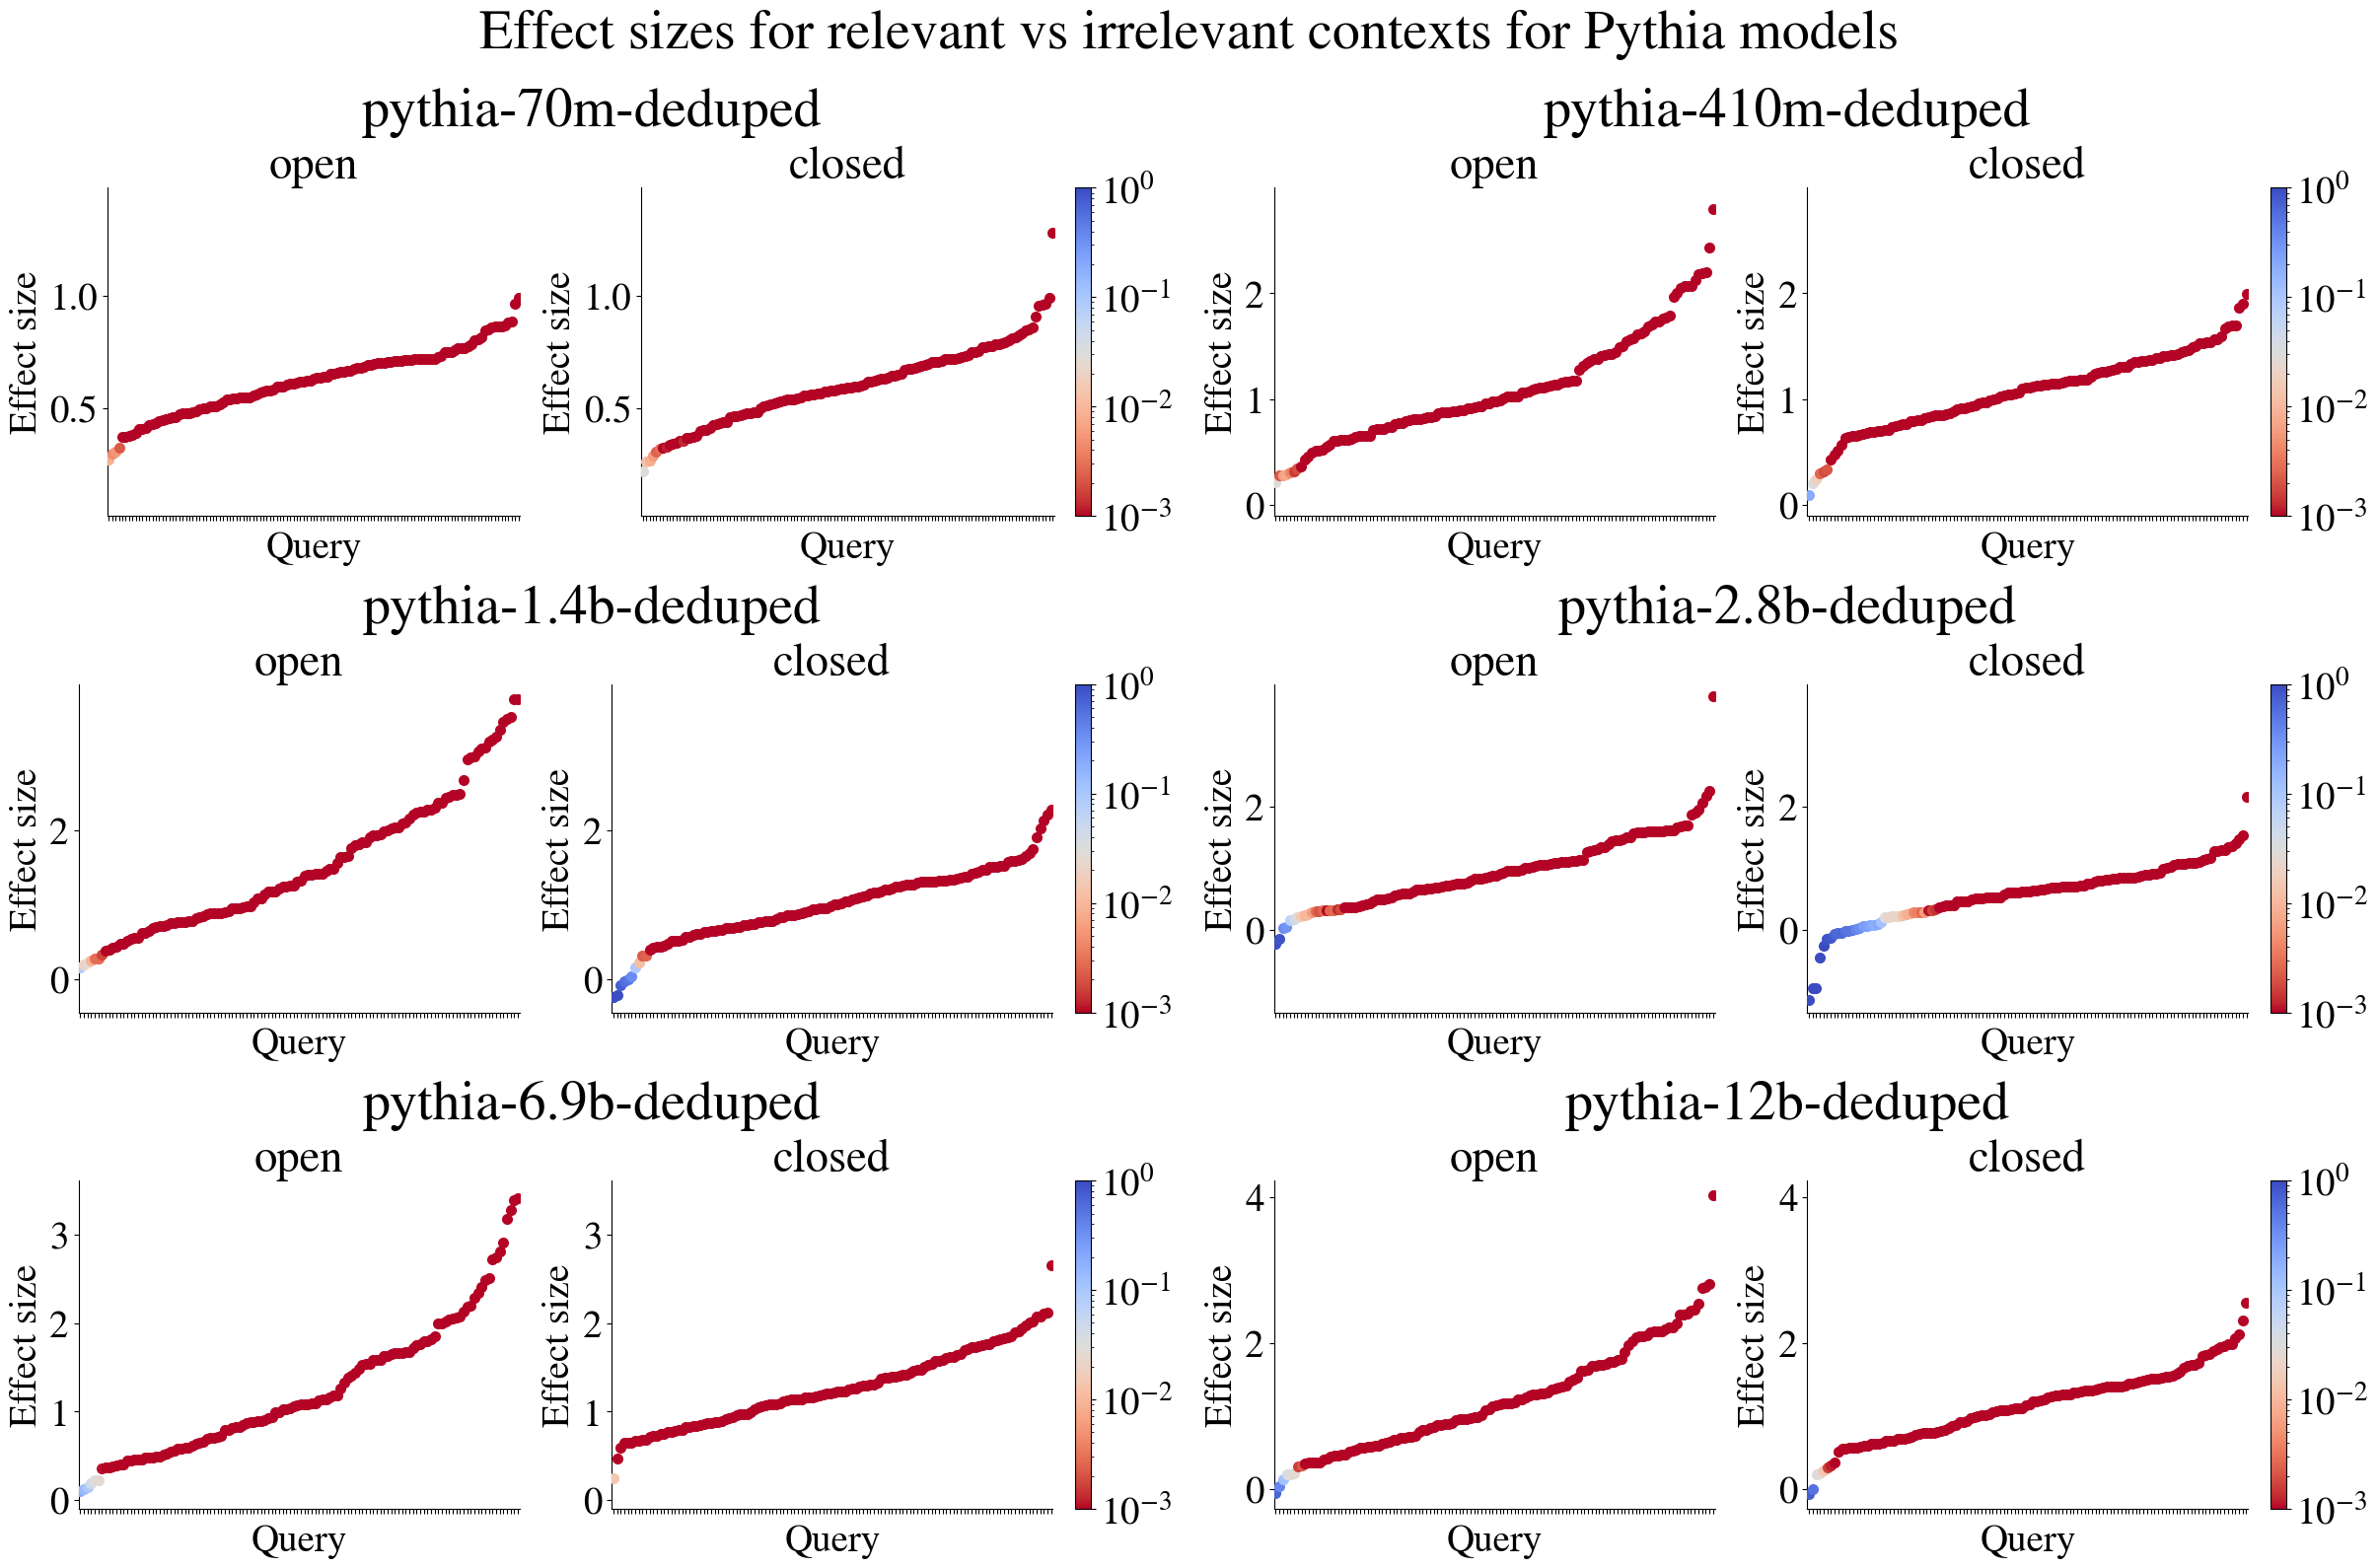

In [36]:
(
    rel_vs_irrel_open_results_per_model,
    rel_vs_irrel_closed_results_per_model,
    rel_vs_irrel_test_results_per_model,
) = get_test_results_and_plot_per_model(
    mean_pscore_relevant_dfs_per_model,
    group1="relevant",
    group2="irrelevant",
    score_col="mean_p_score",
    type_col="context_relevant_vs_irrelevant",
    alternative="greater",
    permutations=10000,
    title="Effect sizes for relevant vs irrelevant contexts for Pythia models",
    save_path=os.path.join(
        analysis_dir, "plot_pscore_relevant_vs_irrelevant_all_models.pdf"
    ),
    cm=cm,
)

/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/cluster/home/kevidu/.local/lib

<Axes: xlabel='Model size', ylabel='Effect size'>

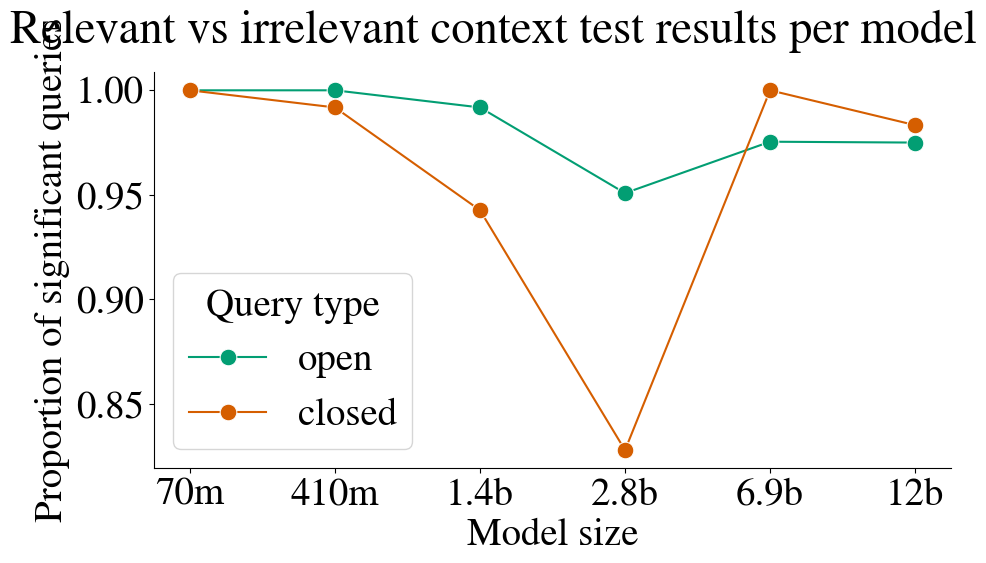

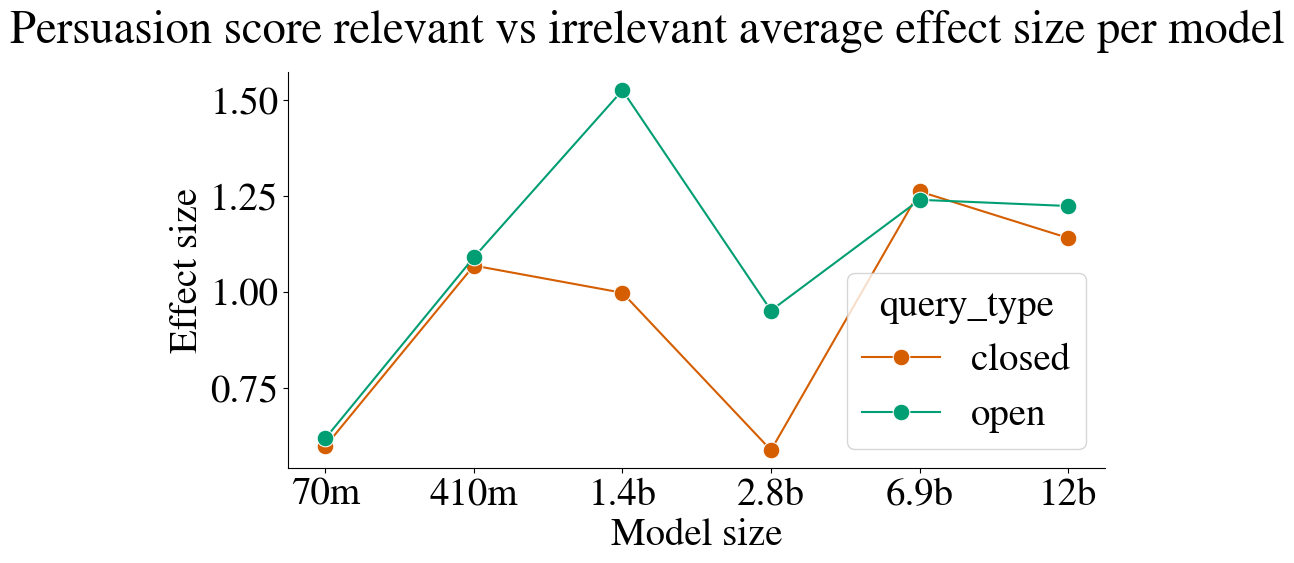

In [37]:
rel_vs_irrel_test_results_per_model_df = convert_test_results_dict_to_sig_proportion_df(
    rel_vs_irrel_test_results_per_model
)
plot_prop_queries_significant_per_model(
    rel_vs_irrel_test_results_per_model_df,
    title="Relevant vs irrelevant context test results per model",
    save_path=os.path.join(
        analysis_dir, "plot_relevant_vs_irrelevant_pval_proportion_all_models.pdf"
    ),
    palette=open_closed_colormap,
)

rel_vs_irrel_mean_effect_sz_df = build_mean_effect_sz_df(
    rel_vs_irrel_open_results_per_model, rel_vs_irrel_closed_results_per_model
)
plot_effect_sz_per_model(
    rel_vs_irrel_mean_effect_sz_df,
    title="Persuasion score relevant vs irrelevant average effect size per model",
    save_path=os.path.join(
        analysis_dir, "plot_pscore_effect_sz_relevant_irrelevant_all_models.pdf"
    ),
    palette=open_closed_colormap,
)

### Aggregated plots

In [38]:
sig_sus_test_results_per_model_df["Comparison"] = "Familiar vs unfamiliar entities"
sig_assertive_test_results_per_model_df["Comparison"] = "Assertive vs base contexts"
negation_test_results_per_model_df["Comparison"] = "Negation vs base contexts"
rel_vs_irrel_test_results_per_model_df["Comparison"] = "Relevant vs irrelevant contexts"
all_tests_combined_df = pd.concat(
    [
        sig_sus_test_results_per_model_df,
        sig_assertive_test_results_per_model_df,
        negation_test_results_per_model_df,
        rel_vs_irrel_test_results_per_model_df,
    ]
)
all_tests_combined_df

model_name Model size  Model size count Query type  \
2    EleutherAI/pythia-70m-deduped        70m      7.000000e+07       open   
6    EleutherAI/pythia-70m-deduped        70m      7.000000e+07     closed   
14  EleutherAI/pythia-410m-deduped       410m      4.100000e+08     closed   
10  EleutherAI/pythia-410m-deduped       410m      4.100000e+08       open   
22  EleutherAI/pythia-1.4b-deduped       1.4b      1.400000e+09     closed   
18  EleutherAI/pythia-1.4b-deduped       1.4b      1.400000e+09       open   
26  EleutherAI/pythia-2.8b-deduped       2.8b      2.800000e+09       open   
30  EleutherAI/pythia-2.8b-deduped       2.8b      2.800000e+09     closed   
38  EleutherAI/pythia-6.9b-deduped       6.9b      6.900000e+09     closed   
34  EleutherAI/pythia-6.9b-deduped       6.9b      6.900000e+09       open   
46   EleutherAI/pythia-12b-deduped        12b      1.200000e+10     closed   
42   EleutherAI/pythia-12b-deduped        12b      1.200000e+10       open   
2    EleutherAI/pythia-70m-deduped        70m      7.000000e+07       open   
6    EleutherAI/pythia-70m-deduped        70m      7.000000e+07     closed   
14  EleutherAI/pythia-410m-deduped       410m      4.100000e+08     closed   
10  EleutherAI/pythia-410m-deduped       410m      4.100000e+08       open   
22  EleutherAI/pythia-1.4b-deduped       1.4b      1.400000e+09     closed   
18  EleutherAI/pythia-1.4b-deduped       1.4b      1.400000e+09       open   
26  EleutherAI/pythia-2.8b-deduped       2.8b      2.800000e+09       open   
30  EleutherAI/pythia-2.8b-deduped       2.8b      2.800000e+09     closed   
38  EleutherAI/pythia-6.9b-deduped       6.9b      6.900000e+09     closed   
34  EleutherAI/pythia-6.9b-deduped       6.9b      6.900000e+09       open   
46   EleutherAI/pythia-12b-deduped        12b      1.200000e+10     closed   
42   EleutherAI/pythia-12b-deduped        12b      1.200000e+10       open   
2    EleutherAI/pythia-70m-deduped        70m      7.000000e+07       open   
6    EleutherAI/pythia-70m-deduped        70m      7.000000e+07     closed   
14  EleutherAI/pythia-410m-deduped       410m      4.100000e+08     closed   
10  EleutherAI/pythia-410m-deduped       410m      4.100000e+08       open   
22  EleutherAI/pythia-1.4b-deduped       1.4b      1.400000e+09     closed   
18  EleutherAI/pythia-1.4b-deduped       1.4b      1.400000e+09       open   
26  EleutherAI/pythia-2.8b-deduped       2.8b      2.800000e+09       open   
30  EleutherAI/pythia-2.8b-deduped       2.8b      2.800000e+09     closed   
38  EleutherAI/pythia-6.9b-deduped       6.9b      6.900000e+09     closed   
34  EleutherAI/pythia-6.9b-deduped       6.9b      6.900000e+09       open   
46   EleutherAI/pythia-12b-deduped        12b      1.200000e+10     closed   
42   EleutherAI/pythia-12b-deduped        12b      1.200000e+10       open   
2    EleutherAI/pythia-70m-deduped        70m      7.000000e+07       open   
6    EleutherAI/pythia-70m-deduped        70m      7.000000e+07     closed   
14  EleutherAI/pythia-410m-deduped       410m      4.100000e+08     closed   
10  EleutherAI/pythia-410m-deduped       410m      4.100000e+08       open   
22  EleutherAI/pythia-1.4b-deduped       1.4b      1.400000e+09     closed   
18  EleutherAI/pythia-1.4b-deduped       1.4b      1.400000e+09       open   
26  EleutherAI/pythia-2.8b-deduped       2.8b      2.800000e+09       open   
30  EleutherAI/pythia-2.8b-deduped       2.8b      2.800000e+09     closed   
38  EleutherAI/pythia-6.9b-deduped       6.9b      6.900000e+09     closed   
34  EleutherAI/pythia-6.9b-deduped       6.9b      6.900000e+09       open   
46   EleutherAI/pythia-12b-deduped        12b      1.200000e+10     closed   
42   EleutherAI/pythia-12b-deduped        12b      1.200000e+10       open   

   metric_type             significance     value  \
2   proportion    significant (greater)  0.000000   
6   proportion    significant (greater)  0.170732   
14  proportion    significant (greater)  0

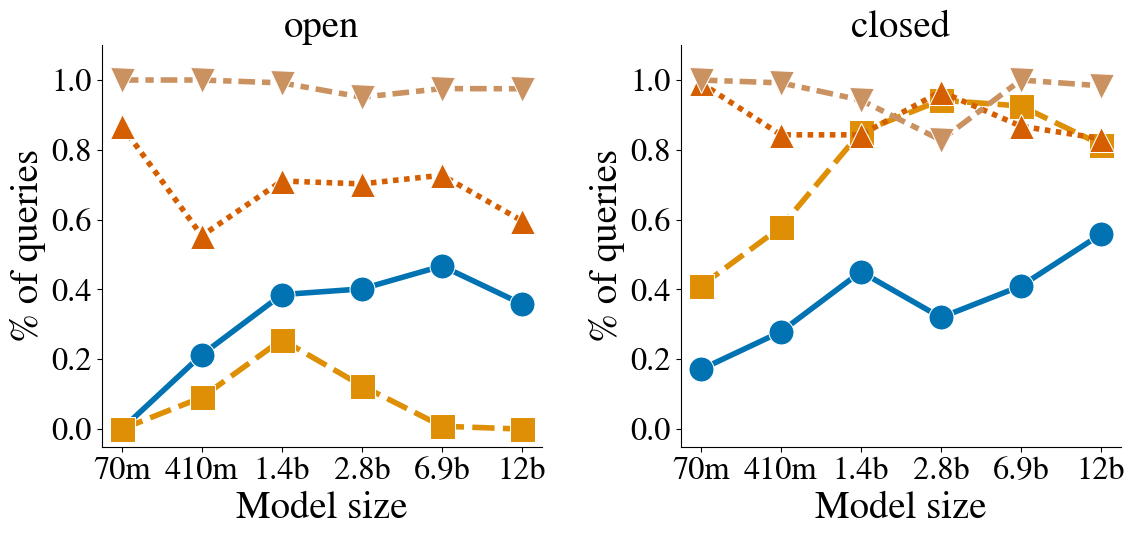

In [39]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for i, qt in enumerate(
    sorted(all_tests_combined_df["Query type"].unique(), reverse=True)
):
    ax = axes[i]
    sns.lineplot(
        data=all_tests_combined_df[all_tests_combined_df["Query type"] == qt],
        x="Model size",
        y="value",
        hue="Comparison",
        style="Comparison",
        markers=["o", "s", "^", "v"],
        markersize=18,
        linewidth=4,
        ax=ax,
        legend=None,
        # legend=None if i == 0 else True,
        palette=comparison_colormap,
    )
    ax.set_title(qt, size="medium")
    ax.set_xlabel("Model size", size="medium")
    ax.set_ylabel("% of queries", size="medium")
    ax.set_ylim(-0.05, 1.1)
    ax.tick_params(axis="both", which="major", labelsize="small")


# fig.suptitle(
#     "% of queries with significant results",
#     # "% of queries with significant results for different comparisons and models",
#     y=0.92,
# )
plt.tight_layout()

plot_name = f"plot_comparisons_prop_sig_models_all"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

This plot indicates the proportion of queries for which (bronze down triangles) relevant contexts are significantly more persuasive than irrelevant contexts, (blue circles) unfamiliar entities are significantly more susceptible than familiar entities, (yellow squares) assertive contexts are significantly more persuasive than base contexts, and (orange triangles) negation contexts are significantly more persuasive than base contexts.

In [40]:
sus_mean_effect_sz_df["Comparison"] = "Familiar vs unfamiliar entities"
assertive_mean_effect_sz_df["Comparison"] = "Assertive vs base contexts"
negation_mean_effect_sz_df["Comparison"] = "Negation vs base contexts"
rel_vs_irrel_mean_effect_sz_df["Comparison"] = "Relevant vs irrelevant contexts"
all_effect_szs_combined_df = pd.concat(
    [
        sus_mean_effect_sz_df,
        assertive_mean_effect_sz_df,
        negation_mean_effect_sz_df,
        rel_vs_irrel_mean_effect_sz_df,
    ]
)
all_effect_szs_combined_df

model_name Model size query_type  mean_effect_sz  \
10   EleutherAI/pythia-70m-deduped        70m     closed        0.073828   
11   EleutherAI/pythia-70m-deduped        70m       open        0.039495   
6   EleutherAI/pythia-410m-deduped       410m     closed        0.244951   
7   EleutherAI/pythia-410m-deduped       410m       open        0.236352   
0   EleutherAI/pythia-1.4b-deduped       1.4b     closed        0.292160   
1   EleutherAI/pythia-1.4b-deduped       1.4b       open        0.420033   
4   EleutherAI/pythia-2.8b-deduped       2.8b     closed        0.146606   
5   EleutherAI/pythia-2.8b-deduped       2.8b       open        0.360225   
8   EleutherAI/pythia-6.9b-deduped       6.9b     closed        0.242004   
9   EleutherAI/pythia-6.9b-deduped       6.9b       open        0.402046   
2    EleutherAI/pythia-12b-deduped        12b     closed        0.357457   
3    EleutherAI/pythia-12b-deduped        12b       open        0.302460   
10   EleutherAI/pythia-70m-deduped        70m     closed        0.241950   
11   EleutherAI/pythia-70m-deduped        70m       open       -0.220361   
6   EleutherAI/pythia-410m-deduped       410m     closed        0.496544   
7   EleutherAI/pythia-410m-deduped       410m       open       -0.060142   
0   EleutherAI/pythia-1.4b-deduped       1.4b     closed        1.441052   
1   EleutherAI/pythia-1.4b-deduped       1.4b       open        0.087568   
4   EleutherAI/pythia-2.8b-deduped       2.8b     closed        2.528078   
5   EleutherAI/pythia-2.8b-deduped       2.8b       open        0.025646   
8   EleutherAI/pythia-6.9b-deduped       6.9b     closed        1.772613   
9   EleutherAI/pythia-6.9b-deduped       6.9b       open       -0.156349   
2    EleutherAI/pythia-12b-deduped        12b     closed        1.331763   
3    EleutherAI/pythia-12b-deduped        12b       open       -0.165163   
10   EleutherAI/pythia-70m-deduped        70m     closed        1.959444   
11   EleutherAI/pythia-70m-deduped        70m       open       -0.447927   
6   EleutherAI/pythia-410m-deduped       410m     closed       -0.450253   
7   EleutherAI/pythia-410m-deduped       410m       open       -0.144051   
0   EleutherAI/pythia-1.4b-deduped       1.4b     closed       -0.761057   
1   EleutherAI/pythia-1.4b-deduped       1.4b       open       -0.140013   
4   EleutherAI/pythia-2.8b-deduped       2.8b     closed        2.063129   
5   EleutherAI/pythia-2.8b-deduped       2.8b       open        0.229111   
8   EleutherAI/pythia-6.9b-deduped       6.9b     closed       -0.120750   
9   EleutherAI/pythia-6.9b-deduped       6.9b       open       -0.046661   
2    EleutherAI/pythia-12b-deduped        12b     closed       -0.098223   
3    EleutherAI/pythia-12b-deduped        12b       open        0.107821   
10   EleutherAI/pythia-70m-deduped        70m     closed        0.598372   
11   EleutherAI/pythia-70m-deduped        70m       open        0.619037   
6   EleutherAI/pythia-410m-deduped       410m     closed        1.069412   
7   EleutherAI/pythia-410m-deduped       410m       open        1.090820   
0   EleutherAI/pythia-1.4b-deduped       1.4b     closed        0.998499   
1   EleutherAI/pythia-1.4b-deduped       1.4b       open        1.526000   
4   EleutherAI/pythia-2.8b-deduped       2.8b     closed        0.588489   
5   EleutherAI/pythia-2.8b-deduped       2.8b       open        0.952333   
8   EleutherAI/pythia-6.9b-deduped       6.9b     closed        1.262497   
9   EleutherAI/pythia-6.9b-deduped       6.9b       open        1.240750   
2    EleutherAI/pythia-12b-deduped        12b     closed        1.141218   
3    EleutherAI/pythia-12b-deduped        12b       open        1.224586   

    Model size count                       Comparison  
10      7.000000e+07  Familiar vs unfamiliar entities  
11      7.000000e+07  Familiar vs unfamiliar entities  
6       4.100000e+08  Familiar vs unfamiliar entities  
7       4.100000e+08  Familiar vs unfamiliar entities  
0       1.400000e+0

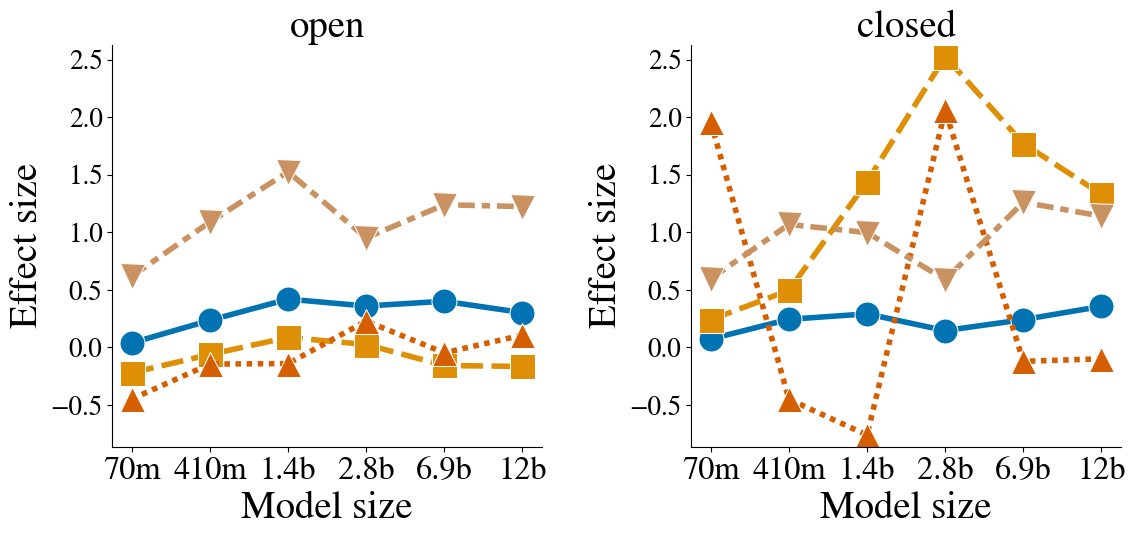

In [41]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for i, qt in enumerate(
    sorted(all_effect_szs_combined_df["query_type"].unique(), reverse=True)
):
    ax = axes[i]
    sns.lineplot(
        data=all_effect_szs_combined_df[all_effect_szs_combined_df["query_type"] == qt],
        x="Model size",
        y="mean_effect_sz",
        hue="Comparison",
        style="Comparison",
        markers=["o", "s", "^", "v"],
        markersize=18,  # 16
        linewidth=4,  # 3
        ax=ax,
        legend=None,
        # legend=None if i == 0 else True,
        palette=comparison_colormap,
    )
    ax.set_title(qt, size="medium")
    ax.set_xlabel("Model size", size="medium")
    ax.set_ylabel("Effect size", size="medium")
    ax.tick_params(axis="x", which="major", labelsize="small")
    ax.tick_params(axis="y", which="major", labelsize="x-small")
    ax.set_ylim(
        all_effect_szs_combined_df["mean_effect_sz"].min() - 0.1,
        all_effect_szs_combined_df["mean_effect_sz"].max() + 0.1,
    )

# fig.suptitle(
#     " ",
#     # "Mean effect size for different comparisons and models",
#     y=0.92,
# )
plt.tight_layout()
# plt.subplots_adjust(right=0.75)  # Adjust this value based on your figure size

plot_name = f"plot_comparisons_effect_szs_models_all"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

In [42]:
print(
    json.dumps(
        {k: matplotlib.colors.rgb2hex(v) for k, v in comparison_colormap.items()},
        indent=2,
    )
)

{
  "Familiar vs unfamiliar entities": "#0173b2",
  "Assertive vs base contexts": "#de8f05",
  "Negation vs base contexts": "#d55e00",
  "Relevant vs irrelevant contexts": "#ca9161"
}


This plot indicates, as measured by average effect size over queries, the degree to which (bronze down triangles) relevant contexts are more persuasive than irrelevant contexts, (blue circles) unfamiliar entities are more susceptible than familiar entities, (yellow squares) assertive contexts are more persuasive than base contexts, and (orange triangles) negation contexts are more persuasive than base contexts.

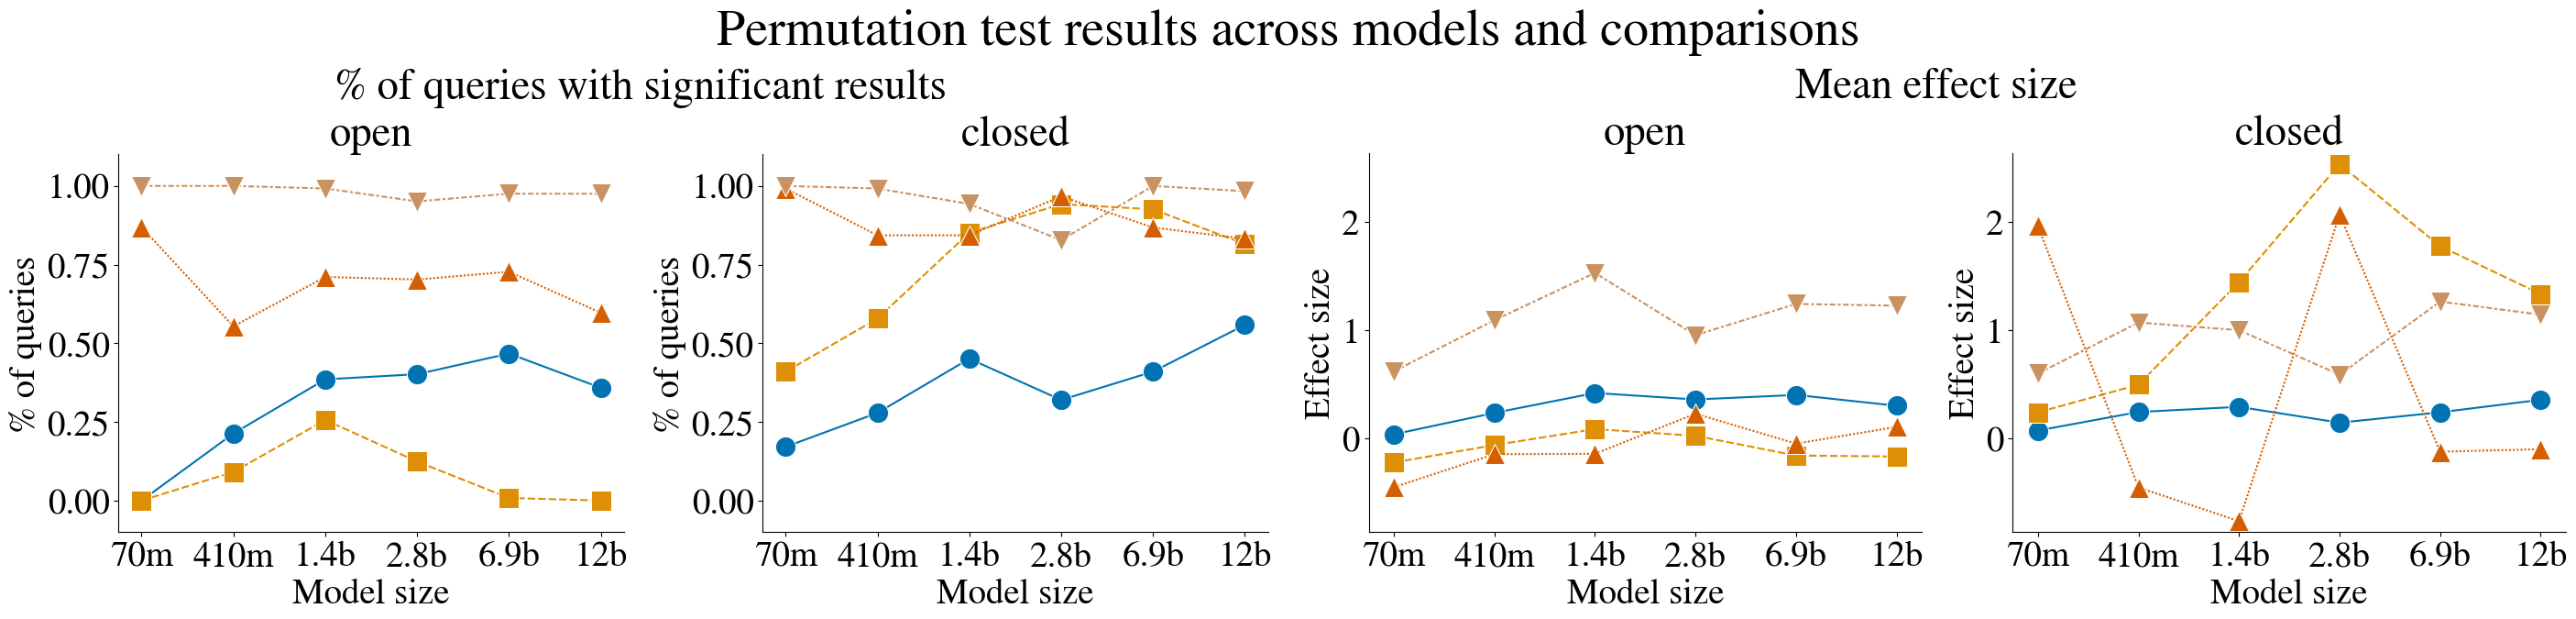

In [43]:
fig = plt.figure(constrained_layout=True, figsize=(28, 6))
subfigs = fig.subfigures(nrows=1, ncols=2)

axes = subfigs[0].subplots(nrows=1, ncols=2)
for i, qt in enumerate(
    sorted(all_tests_combined_df["Query type"].unique(), reverse=True)
):
    ax = axes[i]
    sns.lineplot(
        data=all_tests_combined_df[all_tests_combined_df["Query type"] == qt],
        x="Model size",
        y="value",
        hue="Comparison",
        style="Comparison",
        markers=["o", "s", "^", "v"],
        markersize=16,
        ax=ax,
        legend=None,
        # legend=None if i == 0 else True,
        palette=comparison_colormap,
    )
    ax.set_title(qt)
    ax.set_xlabel("Model size")
    ax.set_ylabel("% of queries")
    ax.set_ylim(-0.1, 1.1)

subfigs[0].suptitle(
    "% of queries with significant results",
    # size="medium",
)

axes = subfigs[1].subplots(nrows=1, ncols=2)
for i, qt in enumerate(
    sorted(all_effect_szs_combined_df["query_type"].unique(), reverse=True)
):
    ax = axes[i]
    sns.lineplot(
        data=all_effect_szs_combined_df[all_effect_szs_combined_df["query_type"] == qt],
        x="Model size",
        y="mean_effect_sz",
        hue="Comparison",
        style="Comparison",
        markers=["o", "s", "^", "v"],
        markersize=16,
        ax=ax,
        legend=None,
        # legend=None if i == 0 else True,
        palette=comparison_colormap,
    )
    ax.set_title(qt)
    ax.set_xlabel("Model size")
    ax.set_ylabel("Effect size")
    ax.set_ylim(
        all_effect_szs_combined_df["mean_effect_sz"].min() - 0.1,
        all_effect_szs_combined_df["mean_effect_sz"].max() + 0.1,
    )

subfigs[1].suptitle(
    "Mean effect size",
    # size="medium",
)

fig.suptitle(
    "Permutation test results across models and comparisons",
    y=1.1,
    size="x-large",
)

plot_name = f"plot_prop_sig_and_effect_szs_comparisons_models_all"
save_path = os.path.join(analysis_dir, f"{plot_name}.pdf")
fig.savefig(save_path, bbox_inches="tight")

In [44]:
for (_, ef_df), (_, prop_df) in zip(
    all_effect_szs_combined_df.groupby(["query_type", "Comparison"]),
    all_tests_combined_df.groupby(["Query type", "Comparison"]),
):
    ef_df = ef_df.rename(
        columns={"query_type": "Query type", "mean_effect_sz": "Mean effect size"}
    )
    ef_df_full = ef_df.copy()

    ef_df = ef_df[
        [
            "Model size",
            # "Comparison",
            # "Query type",
            "Mean effect size",
        ]
    ]
    # prop_df = prop_df.rename(columns={"value": "% relations with significant result"})
    prop_df = prop_df.rename(columns={"value": "% relations w/ sig. result"})
    prop_df = prop_df[prop_df["significance"] != "insignificant"][
        [
            "Model size",
            # "Comparison",
            # "Query type",
            "% relations w/ sig. result",
        ]
    ]
    print(
        f"{ef_df_full['Comparison'].iloc[0]}, {ef_df_full['Query type'].iloc[0]} queries"
    )
    print(prop_df.merge(ef_df).to_markdown(index=False, floatfmt=".2f"))
    # print(
    #     .to_markdown(index=False)
    # )
    print("\n\n")
    # print(prop_df)

Assertive vs base contexts, closed queries
| Model size   |   % relations w/ sig. result |   Mean effect size |
|:-------------|-----------------------------:|-------------------:|
| 70m          |                         0.41 |               0.24 |
| 410m         |                         0.58 |               0.50 |
| 1.4b         |                         0.85 |               1.44 |
| 2.8b         |                         0.94 |               2.53 |
| 6.9b         |                         0.93 |               1.77 |
| 12b          |                         0.82 |               1.33 |



Familiar vs unfamiliar entities, closed queries
| Model size   |   % relations w/ sig. result |   Mean effect size |
|:-------------|-----------------------------:|-------------------:|
| 70m          |                         0.17 |               0.07 |
| 410m         |                         0.28 |               0.24 |
| 1.4b         |                         0.45 |               0.29 |
| 2.8b   